In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Install phew by running command '! pip install phew' in the notebook or 'pip install phew' in other python-enabled command prompts
# Developed by Precious Nliwasa
# For the purpose of this work, we will not use the package, we will just define the methods as written in the package but you can use the package if interested

# from phew import Cola
# from phew import Premium
# from phew import Expenses
# from phew import Interest_rates
# from phew import Time_value
# from phew import Annuity

#### for more info on phew, visit https://github.com/preciousNliwasa/phew . Loss function being used in this notebook is different from the one on phew because of methodology changes

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
plt.style.use('seaborn-darkgrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 5),
    titlesize=20,
    titleweight='bold'
)
%config InlineBackend.figure_format = 'retina'

<h2 style = 'background-color:teal;padding:10px;color:white;border-radius:10px;text-align:center;margin-left:150px;margin-right:170px;'> Trip delay losses framework </h2>

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:600px'> Benefit adjustment </h3>

In [7]:
# importing expected cpi data , 2010 as base year
exp_cpi = pd.read_csv('cpi_forecast.csv')

In [8]:
# transforming data
exp_cpi.columns = ['Date','CPI']
exp_cpi.index = exp_cpi.Date
exp_cpi.drop('Date',axis = 'columns',inplace = True)
exp_cpi

,CPI
Date,
2018-01-01,421.491047
2019-01-01,502.273135
2020-01-01,598.537749
2021-01-01,713.252237
2022-01-01,849.952662
2023-01-01,1012.852803
2024-01-01,1206.974044
2025-01-01,1438.300153
2026-01-01,1713.961739


In [9]:
# estimating cpi from one year to another
exp_cpi_year2year = (exp_cpi.CPI.diff() / 100) + 1
exp_cpi_year2year = pd.DataFrame(exp_cpi_year2year)
exp_cpi_year2year.columns = ['CPI']
exp_cpi_year2year

,CPI
Date,
2018-01-01,NaN
2019-01-01,1.807821
2020-01-01,1.962646
2021-01-01,2.147145
2022-01-01,2.367004
2023-01-01,2.629001
2024-01-01,2.941212
2025-01-01,3.313261
2026-01-01,3.756616


In [10]:
# importing expected inflation data
exp_infla = pd.read_csv('inflation_forecast.csv')

In [11]:
# transforming data
exp_infla.columns = ['Date','Inflation']
exp_infla.index = exp_infla.Date
exp_infla.drop('Date',axis = 'columns',inplace = True)
exp_infla

,Inflation
Date,
2023-12-31,30.158579
2024-12-31,10.904419
2025-12-31,28.428563
2026-12-31,15.508667
2027-12-31,15.486050
2028-12-31,15.463467
2029-12-31,15.440917


In [12]:
cost_of_benefit = 10000 # according to prices in january, 2024

In [13]:
# cpi to simulate benefit growth in the next five years
cpi_vs = [i[0] for i in exp_cpi_year2year.iloc[7::].values]
cpi_vs

[3.3132610956520057,
 3.756615857435081,
 4.2849430614405986,
 4.914528347430755,
 5.664778626670886]

In [14]:
# inflation rates to simulate benefit growth in the next five years
inflation_vs = [i[0] for i in exp_infla.iloc[1::].values]
inflation_vs

[10.904418954938349,
 28.42856259360512,
 15.508666579504755,
 15.486050285032386,
 15.463466971910991,
 15.44091659204386]

In [15]:
class Cola():  
    def __init__(self,initial_fund : float,data : list,method : str = 'cpi'):
        
        self.initial_fund = initial_fund
        self.data = data
        self.method = method
        
    def fund_growth(self): 
 
        if self.method == 'cpi':
            
            fund_rates = []
            
            for i,y in zip(self.data,list(range(len(self.data)))):

                if len(fund_rates) == 0:
                    fund_rates.append(i)      
                else:
                    fund_rates.append(i * np.array(fund_rates)[y-1])

            return self.initial_fund * np.array(fund_rates)
        
        elif self.method == 'inflation':
            
            fund_rates = []
            
            for i,y in zip(self.data,list(range(len(self.data)))):
            
                if len(fund_rates) == 0:
                    fund_rates.append(1 + i)
                else:
                    fund_rates.append((1 + i) * np.array(fund_rates)[y-1])
            
            return self.initial_fund * np.array(fund_rates)

$$ B_{n,y} = \prod_{i=1}^{n} x_i B_0 $$ where B_0 is cost of benefit, X_i is the cpi values and B_{n,y} is benefit_amounts_cpi

In [16]:
# benefit growth using cpi method
benefit_amounts_cpi = Cola(initial_fund = cost_of_benefit,data = cpi_vs,method = 'cpi')

In [17]:
benefit_amounts_cpi.fund_growth()

array([   33132.61095652,   124466.49171749,   533331.83006671,
        2621074.39744999, 14847806.22558899])

In [18]:
[i for i in (np.array(inflation_vs) / 100)]

[0.10904418954938348,
 0.28428562593605117,
 0.15508666579504754,
 0.15486050285032385,
 0.1546346697191099,
 0.1544091659204386]

$$ B_{n,y} = \prod_{i=1}^{n} B_0(1 + r_i) $$ where B_0 is cost of benefit, r_i is the inflation rate values and B_{n,y} is benefit_amounts_inflation

In [19]:
# benefit growth using cpi method
benefit_amounts_inflation = Cola(initial_fund = cost_of_benefit,data = [i for i in (np.array(inflation_vs) / 100)],method = 'inflation')

In [20]:
benefit_amounts_inflation.fund_growth()

array([11090.44189549, 14243.29511166, 16452.24026046, 19000.04246021,
       21938.1077507 , 25325.55267036])

#### Conclusion - cpi method seems unrealistic because the predicted cpi values when used in the fund growth model result in very high benefit values which can be said to be a result of the MA(1) failing to properly forecast cpi. The inflation method seems realistic because the movement of the forecast inflation values resembles the movement of the near past inflation . Therefore, output from inflation method is to be used.

In [21]:
benefit_estimates = pd.DataFrame({'Benefit':benefit_amounts_inflation.fund_growth()},index = exp_infla.index[1::])
benefit_estimates

,Benefit
Date,
2024-12-31,11090.441895
2025-12-31,14243.295112
2026-12-31,16452.240260
2027-12-31,19000.042460
2028-12-31,21938.107751
2029-12-31,25325.552670


In [22]:
class probability_of_delay:
    
    def __init__(self,mean : float,std : float,threshold : int):
        self.threshold = threshold
        self.mean = mean
        self.std = std
        
    def get(self):
        
        if self.threshold > 0:
            probability_of_no_delay = stats.norm.cdf(x = self.threshold,loc=self.mean, scale= self.std)
            return 1 - probability_of_no_delay
        return 'threshold not greater than zero'
    
    def histogram(self,size : int):
        rvs = stats.norm.rvs(loc=self.mean, scale= self.std,size = size)
        plt.title('Trip delay distibution',size = 20)
        plt.xlabel('Delay (time after scheduled destination)',size = 15)
        plt.ylabel('Class',size = 15)
        plt.hist(rvs,bins = 'auto')
        plt.show()

$$ Pr(Delay) = 1 - \int_{-\infty}^{180} \frac{1}{\sqrt{2 \pi} \sigma} \cdot \exp \left[ -\frac{1}{2} \left( \frac{z-\mu}{\sigma} \right)^2 \right] \, \mathrm{d}z $$

In [23]:
pr = probability_of_delay(mean = 90,std = 30,threshold = 180)

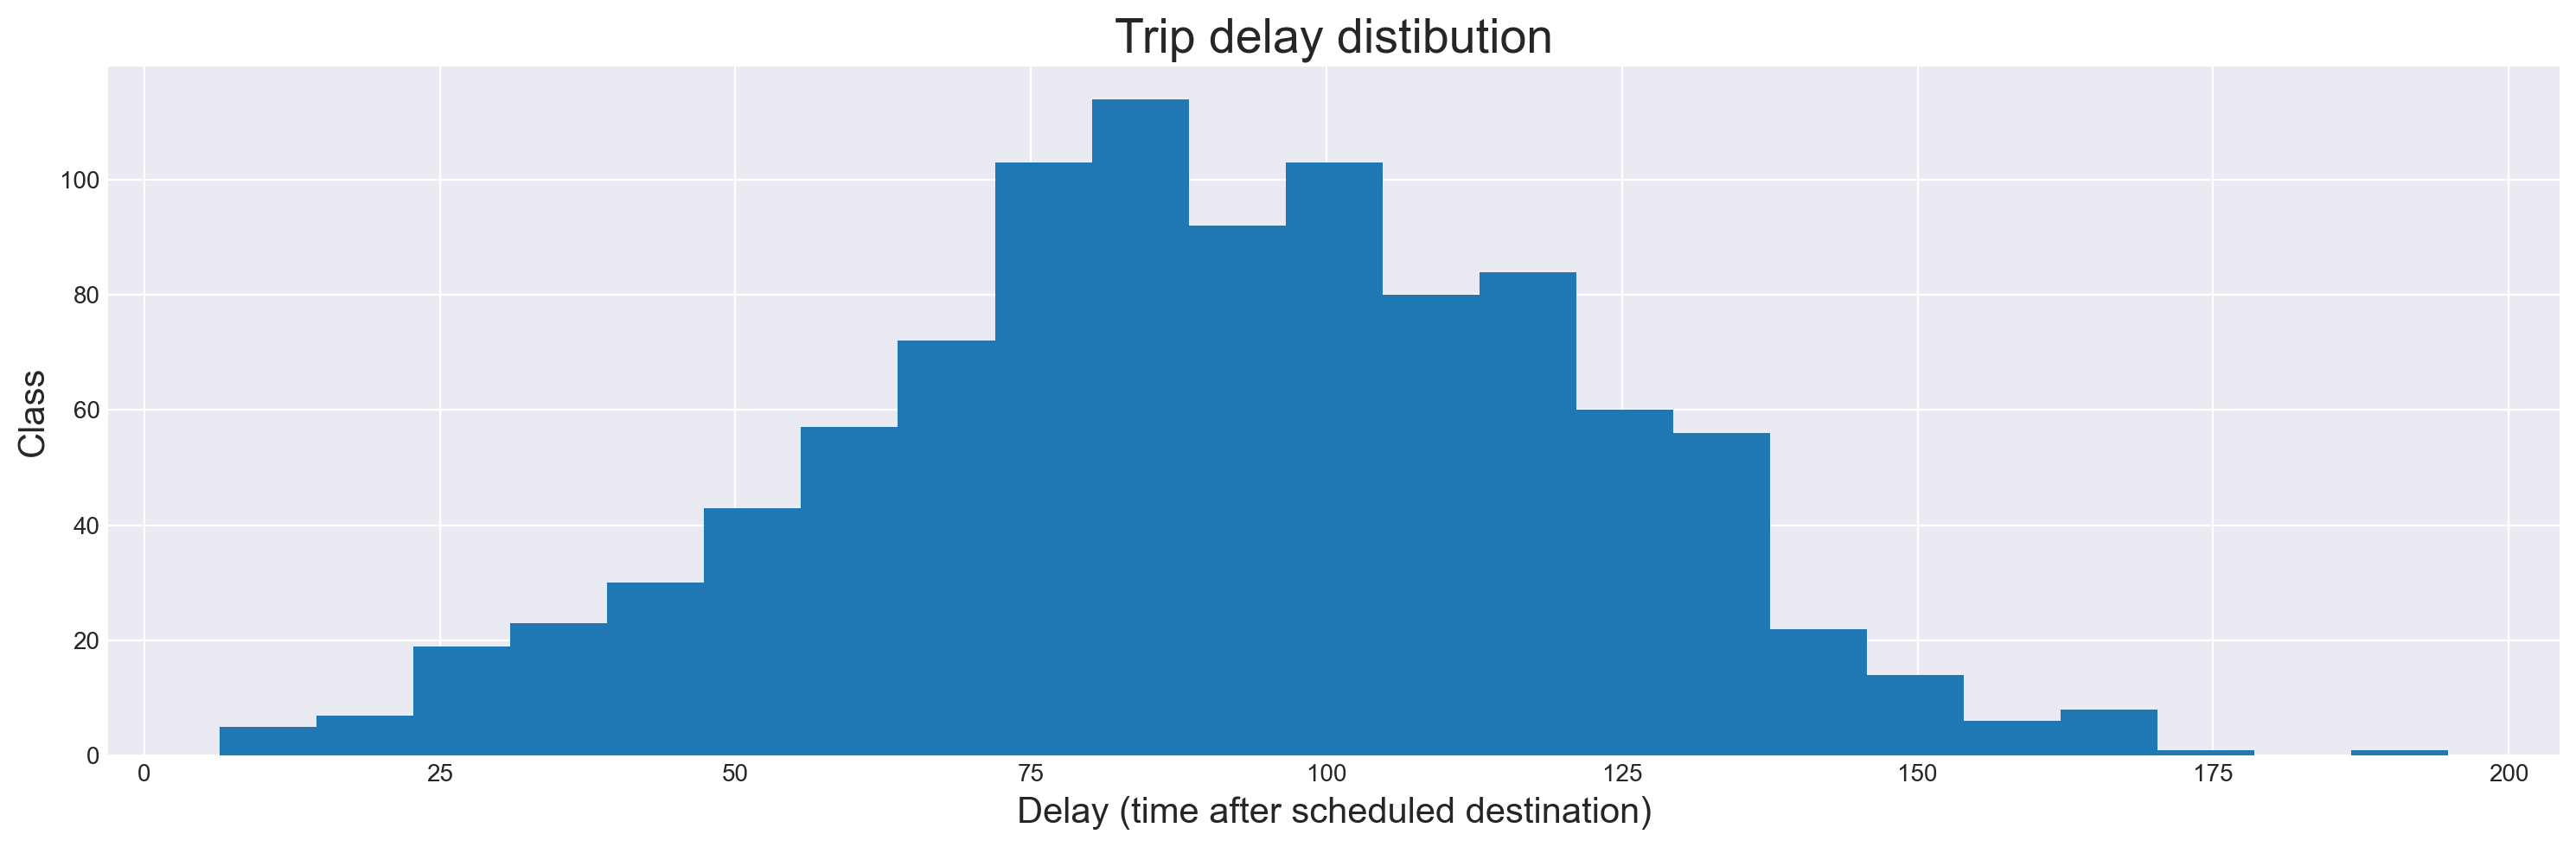

In [24]:
pr.histogram(size = 1000)

In [25]:
pr.get()

0.0013498980316301035

In [26]:
class Loss_given_delay:
    
    def __init__(self,ratio_of_workers_to_population : float,carrying_capacity : int,benefit : float,probability_of_delay : float,number_of_trips : int):
        
        self.ratio_of_workers_to_population = ratio_of_workers_to_population
        self.carrying_capacity = carrying_capacity
        self.benefit = benefit
        self.probability_of_delay = probability_of_delay
        self.number_of_trips = number_of_trips
        
    def get(self):
        
        claims_ = self.ratio_of_workers_to_population * self.carrying_capacity * self.probability_of_delay * self.number_of_trips
        
        return {'Expected claims':claims_,'Loss':claims_ * self.benefit}

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> Loss basis </h3>

In [27]:
# assuming factors such as weather have no effect on delays, model to be used is a one-season model
ratio_of_workers_to_population = 0.1 # formal sector makes 13 percent of the working population, which is 0.1 of the total population
carrying_capacity = 50 


#### Assumption : expected_daily_delays increases by 1 every year. Delays increament being result of growth of transportation business.

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2025 loss </h3>

In [28]:
benefit_2025 = benefit_estimates.loc[benefit_estimates.index == '2025-12-31'].values[0][0]

$$ L_{2025} = R * C * P * N * B_{2025}$$

In [29]:
loss_2025 = Loss_given_delay(ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity= carrying_capacity,benefit = benefit_2025,probability_of_delay = pr.get(),number_of_trips = 500000)

In [30]:
loss_2025.get()

{'Expected claims': 3374.7450790752587, 'Loss': 48067490.087897025}

In [31]:
year_2025_loss = loss_2025.get()['Loss']
year_2025_loss

48067490.087897025

In [32]:
year_2025_claims = loss_2025.get()['Expected claims']
year_2025_claims

3374.7450790752587

In [33]:
# dataframe capturing loss amount amount and expected number of claims in 2025
df_2025_lc = pd.DataFrame({'Year':[2025],'Loss':[year_2025_loss],'Claims' : [year_2025_claims]})
df_2025_lc

,Year,Loss,Claims
0,2025,4.806749e+07,3374.745079


<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2026 loss </h3>

In [34]:
benefit_2026 = benefit_estimates.loc[benefit_estimates.index == '2026-12-31'].values[0][0]

$$ L_{2026} = R * C * P * N * B_{2026}$$

In [35]:
loss_2026 = Loss_given_delay(ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity= carrying_capacity,benefit = benefit_2026,probability_of_delay = pr.get(),number_of_trips = 500000)

In [36]:
year_2026_loss = loss_2026.get()['Loss']
year_2026_loss

55522116.858765475

In [37]:
year_2026_claims = loss_2026.get()['Expected claims']
year_2026_claims

3374.7450790752587

In [38]:
# dataframe capturing loss amount amount and expected number of claims in 2026
df_2026_lc = pd.DataFrame({'Year':[2026],'Loss':[year_2026_loss],'Claims' : [year_2026_claims]})
df_2026_lc

,Year,Loss,Claims
0,2026,5.552212e+07,3374.745079


<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2027 loss </h3>

In [39]:
benefit_2027 = benefit_estimates.loc[benefit_estimates.index == '2027-12-31'].values[0][0]

$$ L_{2027} = R * C * P * N * B_{2027}$$

In [40]:
loss_2027 = Loss_given_delay(ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity= carrying_capacity,benefit = benefit_2027,probability_of_delay = pr.get(),number_of_trips = 500000)

In [41]:
year_2027_loss = loss_2027.get()['Loss']
year_2027_loss

64120299.79482834

In [42]:
year_2027_claims = loss_2027.get()['Expected claims']
year_2027_claims

3374.7450790752587

In [43]:
# dataframe capturing loss amount amount and expected number of claims in 2027
df_2027_lc = pd.DataFrame({'Year':[2027],'Loss':[year_2027_loss],'Claims' : [year_2027_claims]})
df_2027_lc

,Year,Loss,Claims
0,2027,6.412030e+07,3374.745079


<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2028 loss </h3>

In [44]:
benefit_2028 = benefit_estimates.loc[benefit_estimates.index == '2028-12-31'].values[0][0]

$$ L_{2028} = R * C * P * N * B_{2028}$$

In [45]:
loss_2028 = Loss_given_delay(ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity= carrying_capacity,benefit = benefit_2028,probability_of_delay = pr.get(),number_of_trips = 500000)

In [46]:
year_2028_loss = loss_2028.get()['Loss']
year_2028_loss

74035521.17589192

In [47]:
year_2028_claims = loss_2028.get()['Expected claims']
year_2028_claims

3374.7450790752587

In [48]:
# dataframe capturing loss amount amount and expected number of claims in 2028
df_2028_lc = pd.DataFrame({'Year':[2028],'Loss':[year_2028_loss],'Claims' : [year_2028_claims]})
df_2028_lc

,Year,Loss,Claims
0,2028,7.403552e+07,3374.745079


<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> 2029 loss </h3>

In [49]:
benefit_2029 = benefit_estimates.loc[benefit_estimates.index == '2029-12-31'].values[0][0]

$$ L_{2029} = R * C * P * N * B_{2029}$$

In [50]:
loss_2029 = Loss_given_delay(ratio_of_workers_to_population = ratio_of_workers_to_population,carrying_capacity= carrying_capacity,benefit = benefit_2029,probability_of_delay = pr.get(),number_of_trips = 500000)

In [51]:
year_2029_loss = loss_2029.get()['Loss']
year_2029_loss

85467284.24914636

In [52]:
year_2029_claims = loss_2029.get()['Expected claims']
year_2029_claims

3374.7450790752587

In [53]:
# dataframe capturing loss amount amount and expected number of claims in 2029
df_2029_lc = pd.DataFrame({'Year':[2029],'Loss':[year_2029_loss],'Claims' : [year_2029_claims]})
df_2029_lc

,Year,Loss,Claims
0,2029,8.546728e+07,3374.745079


<h2 style = 'background-color:teal;padding:10px;color:white;border-radius:10px;text-align:center;margin-left:150px;margin-right:170px;'> Gross premium calculation </h2>

In [54]:
# concatination of loss and claims dataframes
lc_df = pd.concat([df_2025_lc,df_2026_lc,df_2027_lc,df_2028_lc,df_2029_lc])
lc_df.index = lc_df.Year
lc_df.drop('Year',axis = 'columns',inplace = True)
lc_df

,Loss,Claims
Year,,
2025,4.806749e+07,3374.745079
2026,5.552212e+07,3374.745079
2027,6.412030e+07,3374.745079
2028,7.403552e+07,3374.745079
2029,8.546728e+07,3374.745079


In [55]:
lc_df.Loss

Year
2025    4.806749e+07
2026    5.552212e+07
2027    6.412030e+07
2028    7.403552e+07
2029    8.546728e+07
Name: Loss, dtype: float64

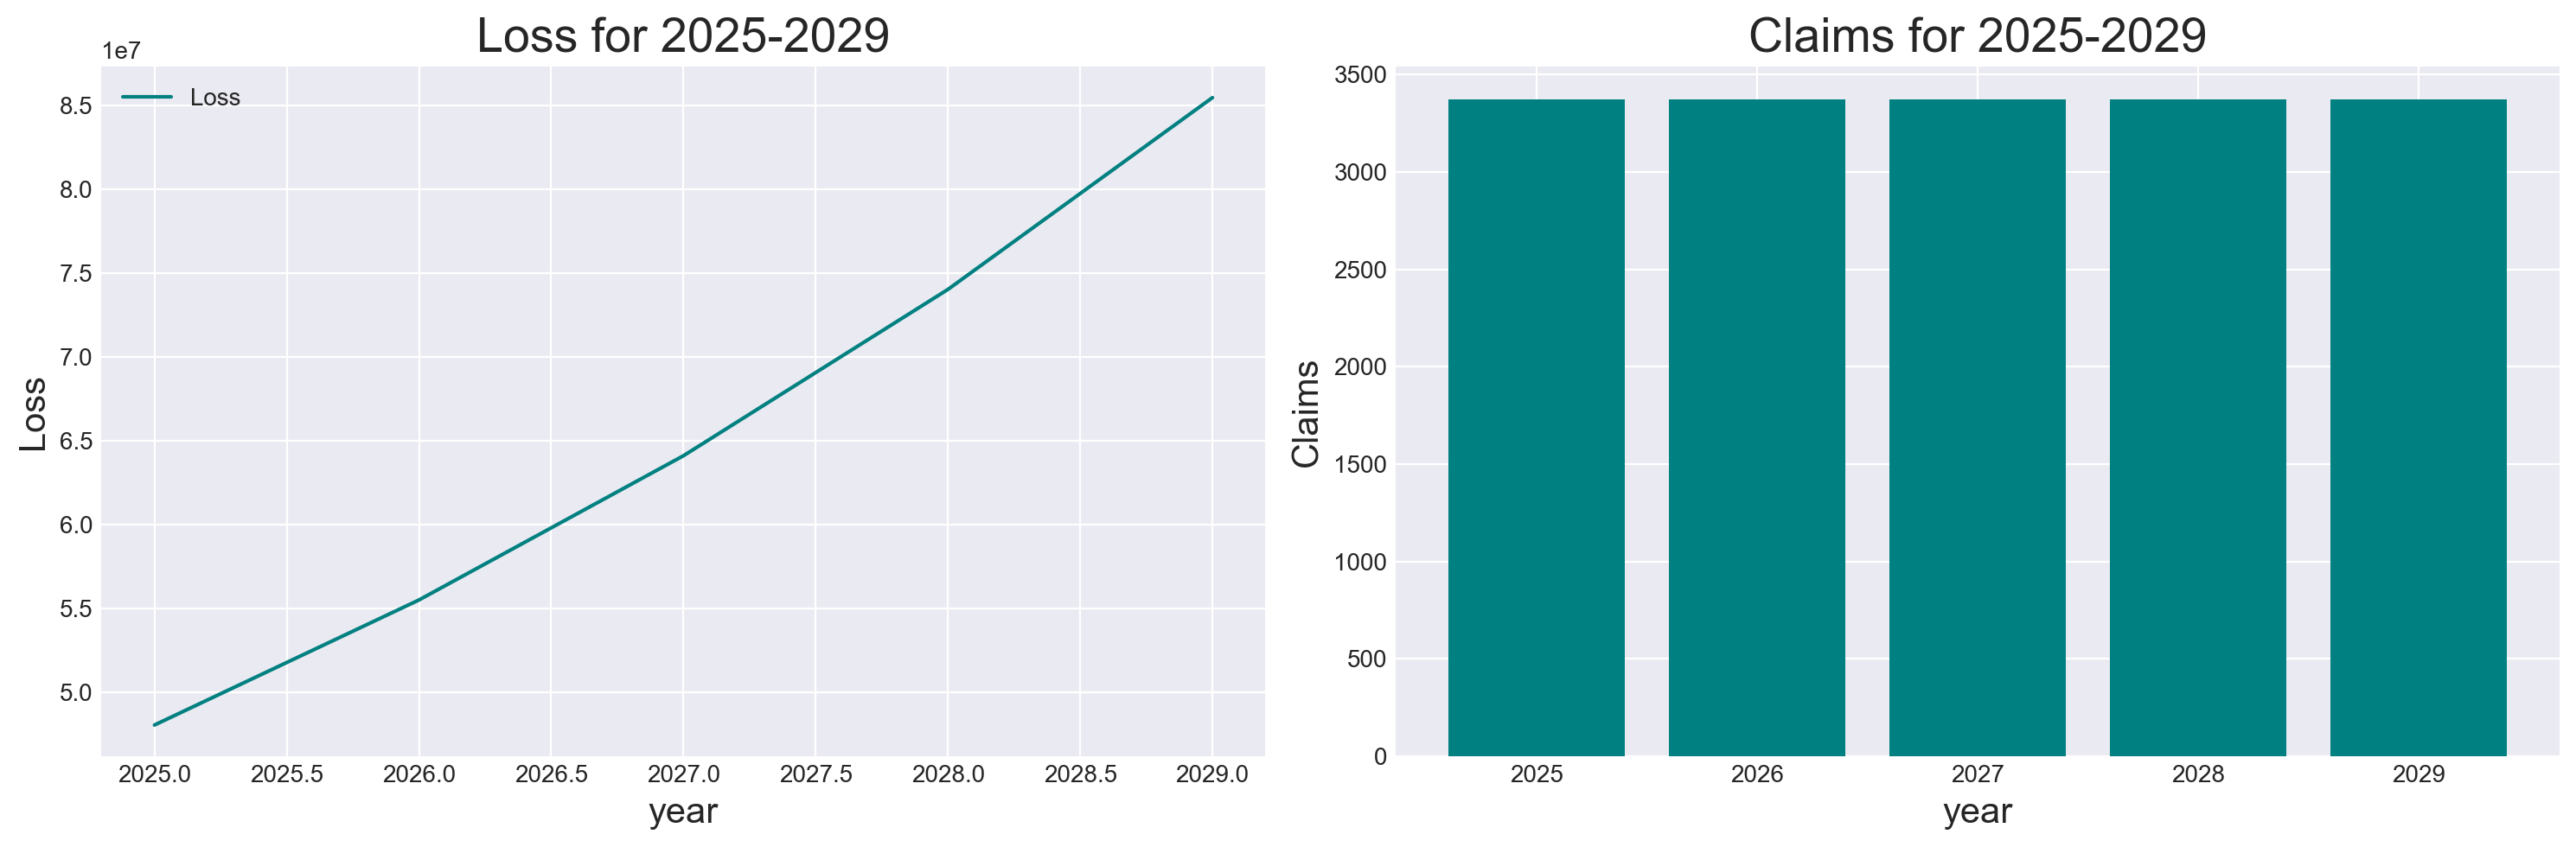

In [56]:
a,(ax,ax2) = plt.subplots(1,2)
ax.plot(lc_df.Loss,label = 'Loss',color = 'teal')
ax.set_title('Loss for 2025-2029',size = 20)
ax.set_xlabel('year',size = 15)
ax.set_ylabel('Loss',size =15)
ax.legend()
plt.bar(list(lc_df.index),list(lc_df.Claims.values),color = 'teal')
ax2.set_title('Claims for 2025-2029',size = 20)
ax2.set_xlabel('year',size = 15)
ax2.set_ylabel('Claims',size =15)
plt.show()

<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> Pure premium calculation </h3>

#### Pure premium = loss / number of exposures

In [62]:
# loading population data, it will help in calculation of number of exposures
population = pd.read_csv('population.csv',sep = '\t')
population.head(14)

,Macrotrends Data Download
0,Malawi Population Growth Rate 1950-2023
1,Original Source: United Nations - World Popula...
2,DISCLAIMER AND TERMS OF USE: HISTORICAL DATA I...
3,FOR INFORMATIONAL PURPOSES - NOT FOR TRADING P...
4,NEITHER MACROTRENDS LLC NOR ANY OF OUR INFORMA...
5,FOR ANY DAMAGES RELATING TO YOUR USE OF THE DA...
6,ATTRIBUTION: Proper attribution requires clear...
7,"A ""dofollow"" backlink to the originating page ..."
8,"date, Population, Annual Growth Rate"
9,"1950-12-31,2949739"


In [63]:
# cleaning data

In [64]:
population[8::]['Macrotrends Data Download'].str.split(',')

8      [date,  Population,  Annual Growth Rate]
9                         [1950-12-31, 2949739]
10                  [1951-12-31, 3001113, 1.74]
11                  [1952-12-31, 3056297, 1.84]
12                  [1953-12-31, 3114930, 1.92]
                         ...                   
155                [2096-12-31, 57624469, 0.43]
156                [2097-12-31, 57861503, 0.41]
157                 [2098-12-31, 58090181, 0.4]
158                [2099-12-31, 58310462, 0.38]
159                [2100-12-31, 58521719, 0.36]
Name: Macrotrends Data Download, Length: 152, dtype: object

In [65]:
population = pd.DataFrame([[r for r in i] for i in population[8::]['Macrotrends Data Download'].str.split(',')])
population.head()

,0,1,2
0,date,Population,Annual Growth Rate
1,1950-12-31,2949739,None
2,1951-12-31,3001113,1.74
3,1952-12-31,3056297,1.84
4,1953-12-31,3114930,1.92


In [66]:
population.columns = population.iloc[0:1:,::].values[0]
population.drop(0,axis = 'rows',inplace = True)

In [67]:
population.drop(' Annual Growth Rate',axis = 'columns',inplace = True) # only interested in population

In [68]:
population.head()

,date,Population
1,1950-12-31,2949739
2,1951-12-31,3001113
3,1952-12-31,3056297
4,1953-12-31,3114930
5,1954-12-31,3176123


In [69]:
population.index = population.date
population.index = pd.to_datetime(population.index)

In [70]:
population.drop('date',axis = 'columns',inplace = True)

In [71]:
population.head()

,Population
date,
1950-12-31,2949739
1951-12-31,3001113
1952-12-31,3056297
1953-12-31,3114930
1954-12-31,3176123


In [72]:
population = population.loc[(population.index >= '2024-12-31') & (population.index <= '2029-12-31')]

In [73]:
population

,Population
date,
2024-12-31,21475962
2025-12-31,22033992
2026-12-31,22601151
2027-12-31,23176271
2028-12-31,23758548
2029-12-31,24347875


#### Assumption : ratio of workers to population (0.1) remains the same throughtout

#### Formula : number of exposures = population * ratio of workers to population

In [74]:
# Exposures dataframe arrived after converting the population values to numeric and multiplying them by 0.1
exposures = pd.DataFrame({'Exposures' : [round(m) for m in np.array([int(i) for i in list(population[' Population'].values)]) * ratio_of_workers_to_population]},index = population.index)
exposures

,Exposures
date,
2024-12-31,2147596
2025-12-31,2203399
2026-12-31,2260115
2027-12-31,2317627
2028-12-31,2375855
2029-12-31,2434788


In [75]:
lc_df

,Loss,Claims
Year,,
2025,4.806749e+07,3374.745079
2026,5.552212e+07,3374.745079
2027,6.412030e+07,3374.745079
2028,7.403552e+07,3374.745079
2029,8.546728e+07,3374.745079


In [76]:
# since exposures in the years before are to fund the present losses
exposures['Exposures shift()'] = exposures.shift()

In [77]:
exposures

,Exposures,Exposures shift()
date,,
2024-12-31,2147596,NaN
2025-12-31,2203399,2147596.0
2026-12-31,2260115,2203399.0
2027-12-31,2317627,2260115.0
2028-12-31,2375855,2317627.0
2029-12-31,2434788,2375855.0


In [78]:
# transforming index to year int format
exposures.index = [str(i).split('-')[0] for i in exposures.index]

In [79]:
exposures

,Exposures,Exposures shift()
2024,2147596,NaN
2025,2203399,2147596.0
2026,2260115,2203399.0
2027,2317627,2260115.0
2028,2375855,2317627.0
2029,2434788,2375855.0


In [80]:
exposures.dropna(inplace = True)

In [81]:
exposures

,Exposures,Exposures shift()
2025,2203399,2147596.0
2026,2260115,2203399.0
2027,2317627,2260115.0
2028,2375855,2317627.0
2029,2434788,2375855.0


In [82]:
class Premium():

    def pure_premium_1(loss : float,exposures : float):
        
        return loss/exposures
    
    def pure_premium_2(frequency : float,severity : float):
        
        return frequency * severity
    
    def gross_rate(pure_premium : float,expense_ratio : float):
        
        return pure_premium / (1 - expense_ratio)
    
    def expense_ratio(fund_costs : float,fund_assets : float):
        
        return fund_costs/fund_assets
    
    def gross_premium(gross_rate : float,units : float):
        
        return gross_rate * units
        

$$ Pure \quad premium = (loss) / (number \quad of \quad exposures) $$

In [83]:
# creating pure premium object
pure_premium_dict = []
for i,k in zip(lc_df.Loss.values,exposures['Exposures shift()']):
    pure_premium = Premium.pure_premium_1(i,k)
    pure_premium_dict.append(pure_premium)

In [84]:
# creating pure premium dataframe
pure_premium_df = pd.DataFrame(pure_premium_dict,columns = ['Pure premium'],index = lc_df.index)
pure_premium_df

,Pure premium
Year,
2025,22.381998
2026,25.198394
2027,28.370370
2028,31.944537
2029,35.973275


<h3 style = 'background-color:peachpuff;padding:10px;border-radius:10px;color:teal;text-align:center;margin-left:0px;width:300px'> Gross rate calculation </h3>

In [85]:
# calculating expenses

In [86]:
# expenses type - system admistration (payment gateway, database adminstration, hosting services) --- just an example

In [87]:
# current expenses -- render (database adminstration and hosting) -29 usd/month
#                  -- authorise.net - payment gateway - 25 usd/month


#### https://render.com/pricing#compute
#### https://www.authorize.net/sign-up/pricing.html

In [88]:
current_amount = 29 + 25

In [89]:
current_amount

54

#### expected us_inflation [2024 : 2.4, 2025 : 2.3, 2026 : 2.3, 2027 : 2.3, 2028 : 2.3, 2029 : 2.3], Source --  https://knoema.com/kyaewad/us-inflation-forecast-2022-2023-and-long-term-to-2030-data-and-charts 

In [90]:
# expected us inflation dataframe
exp_us_infla = pd.DataFrame({'Inflation':[2.4/100,2.3/100,2.3/100,2.3/100,2.3/100,2.3/100]},index = [2024,2025,2026,2027,2028,2029])

In [91]:
exp_us_infla

,Inflation
2024,0.024
2025,0.023
2026,0.023
2027,0.023
2028,0.023
2029,0.023


In [92]:
# initialising cost of living adjustment object to predict future value of the services
exp_adj = Cola(initial_fund = current_amount,data = list(exp_us_infla.Inflation.values),method = 'inflation')

In [93]:
# theamount  growth
exp_adj.fund_growth()

array([55.296     , 56.567808  , 57.86886758, 59.19985154, 60.56144812,
       61.95436143])

In [94]:
exp_price = pd.DataFrame({'Price':exp_adj.fund_growth()},index = ['{}-12-31'.format(i) for i in exp_us_infla.index])

In [95]:
exp_price

,Price
2024-12-31,55.296000
2025-12-31,56.567808
2026-12-31,57.868868
2027-12-31,59.199852
2028-12-31,60.561448
2029-12-31,61.954361


In [96]:
exp_price_refined = pd.DataFrame({'Price':exp_price.Price.shift().dropna().values},index = [list(range(2025,2030))])

In [97]:
exp_price_refined

,Price
2025,55.296000
2026,56.567808
2027,57.868868
2028,59.199852
2029,60.561448


In [98]:
# loading exchange forecast dataframe
exchange_forecast = pd.read_csv('exchange_forecast.csv')

In [99]:
exchange_forecast

,Unnamed: 0,0
0,2024-02-02,1667.818610
1,2024-02-03,1668.838786
2,2024-02-04,1669.580684
3,2024-02-05,1670.406867
4,2024-02-06,1671.352780
...,...,...
2155,2029-12-27,5152.277347
2156,2029-12-28,5154.974709
2157,2029-12-29,5157.673482
2158,2029-12-30,5160.373668


In [100]:
# transforming to workable df

In [101]:
exchange_forecast.columns = ['Date','Buying']
exchange_forecast.index = exchange_forecast.Date

In [102]:
exchange_forecast.index = pd.to_datetime(exchange_forecast.index)

In [103]:
exchange_forecast.drop('Date',axis = 'columns',inplace = True)

In [104]:
exchange_forecast

,Buying
Date,
2024-02-02,1667.818610
2024-02-03,1668.838786
2024-02-04,1669.580684
2024-02-05,1670.406867
2024-02-06,1671.352780
...,...
2029-12-27,5152.277347
2029-12-28,5154.974709
2029-12-29,5157.673482


In [105]:
exchange_forecast = exchange_forecast.loc[(exchange_forecast.index >= '2025-01-01')]

In [106]:
# assuming payment for the service will be made on first day of every month
exchange_forecast = exchange_forecast.loc[exchange_forecast.index.day == 1]

In [107]:
# defining cost function
cost = exchange_forecast

In [108]:
# defining cost column to capture expenses made on the first day of every month
cost['Cost'] = [np.nan for i in cost.index]

In [109]:
cost.head()

,Buying,Cost
Date,,
2025-01-01,1986.439509,NaN
2025-02-01,2018.932618,NaN
2025-03-01,2048.737833,NaN
2025-04-01,2082.249985,NaN
2025-05-01,2115.202944,NaN


In [110]:
cost.tail()

,Buying,Cost
Date,,
2029-08-01,4768.238527,NaN
2029-09-01,4846.234810,NaN
2029-10-01,4922.929622,NaN
2029-11-01,5003.456259,NaN
2029-12-01,5082.639203,NaN


In [111]:
# calculating the expenses by multplying the cost in usd dollars by the price of one us dollar as at that particular date
for i in cost.index.year.unique():
    for x in cost.loc[cost.index.year == i].index:
        cost.loc[cost.index == str(x).split(' ')[0],'Cost'] = cost.loc[cost.index == str(x).split(' ')[0],'Buying'].values[0] * exp_price_refined.loc[exp_price_refined.index == (i,),'Price'].values[0]

In [112]:
cost.head()

,Buying,Cost
Date,,
2025-01-01,1986.439509,109842.159073
2025-02-01,2018.932618,111638.898065
2025-03-01,2048.737833,113287.007231
2025-04-01,2082.249985,115140.095198
2025-05-01,2115.202944,116962.261966


In [113]:
cost.tail()

,Buying,Cost
Date,,
2029-08-01,4768.238527,288771.430202
2029-09-01,4846.234810,293494.998029
2029-10-01,4922.929622,298139.746941
2029-11-01,5003.456259,303016.556657
2029-12-01,5082.639203,307811.990417


In [114]:
# defining year column
cost['Year'] = cost.index.year

In [115]:
cost.head()

,Buying,Cost,Year
Date,,,
2025-01-01,1986.439509,109842.159073,2025
2025-02-01,2018.932618,111638.898065,2025
2025-03-01,2048.737833,113287.007231,2025
2025-04-01,2082.249985,115140.095198,2025
2025-05-01,2115.202944,116962.261966,2025


In [116]:
cost.tail()

,Buying,Cost,Year
Date,,,
2029-08-01,4768.238527,288771.430202,2029
2029-09-01,4846.234810,293494.998029,2029
2029-10-01,4922.929622,298139.746941,2029
2029-11-01,5003.456259,303016.556657,2029
2029-12-01,5082.639203,307811.990417,2029


In [117]:
# calculating total cost by year
cost_by_year = cost.groupby('Year').sum('Cost')

In [118]:
cost_by_year.Cost[2025]

1440298.9058667072

In [119]:
# loading original exchange data
exchange_obs = pd.read_csv('exchangesti.csv')

In [120]:
# standard dev of the values of usd dollar against kwacha from 2012 to 2024, to help in correcting the forecast
std = round(exchange_obs.Buying.std())

In [121]:
class Expenses():
    
    def __init__(self,mean_expenses : float,variance_expenses : float,fund_amount:float):
        self.mean_expenses = mean_expenses
        self.variance_expenses = variance_expenses
        self.fund_amount = fund_amount
        
    def montecarlo(self,alpha : int,number_of_replications:int):
        
        ratio_output_ = []
        expense_output_ = []
        
        for expense in stats.pareto.rvs(loc = self.mean_expenses - 2 * self.variance_expenses,scale = self.variance_expenses,b = alpha,size = number_of_replications):
            ratio_output_.append(expense/self.fund_amount)
            expense_output_.append(expense)
            
        optimal_ratio = np.array(ratio_output_).mean()
        
        return {'optimal_ratio':optimal_ratio,'ratio_output':ratio_output_,'expense_output':expense_output_}
        

In [122]:
# 2025 expenses

In [123]:
expenses_2025 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2025]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2025,),'Price'].values[0] * 12,fund_amount = df_2025_lc.Loss.values[0])

In [124]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2025_dict = expenses_2025.montecarlo(alpha = 5,number_of_replications = 1000)

In [125]:
expenses_2025_dict.keys()

dict_keys(['optimal_ratio', 'ratio_output', 'expense_output'])

$$       \begin{eqnarray} \label{eq:8}
    Expense \quad ratio = \frac{Total \quad fund \quad costs}{Total \quad fund \quad assets}
  \end{eqnarray} $$

In [126]:
# expense ratio for gross rate calculation
or_2025 = expenses_2025_dict['optimal_ratio']
or_2025

0.027236272277638755

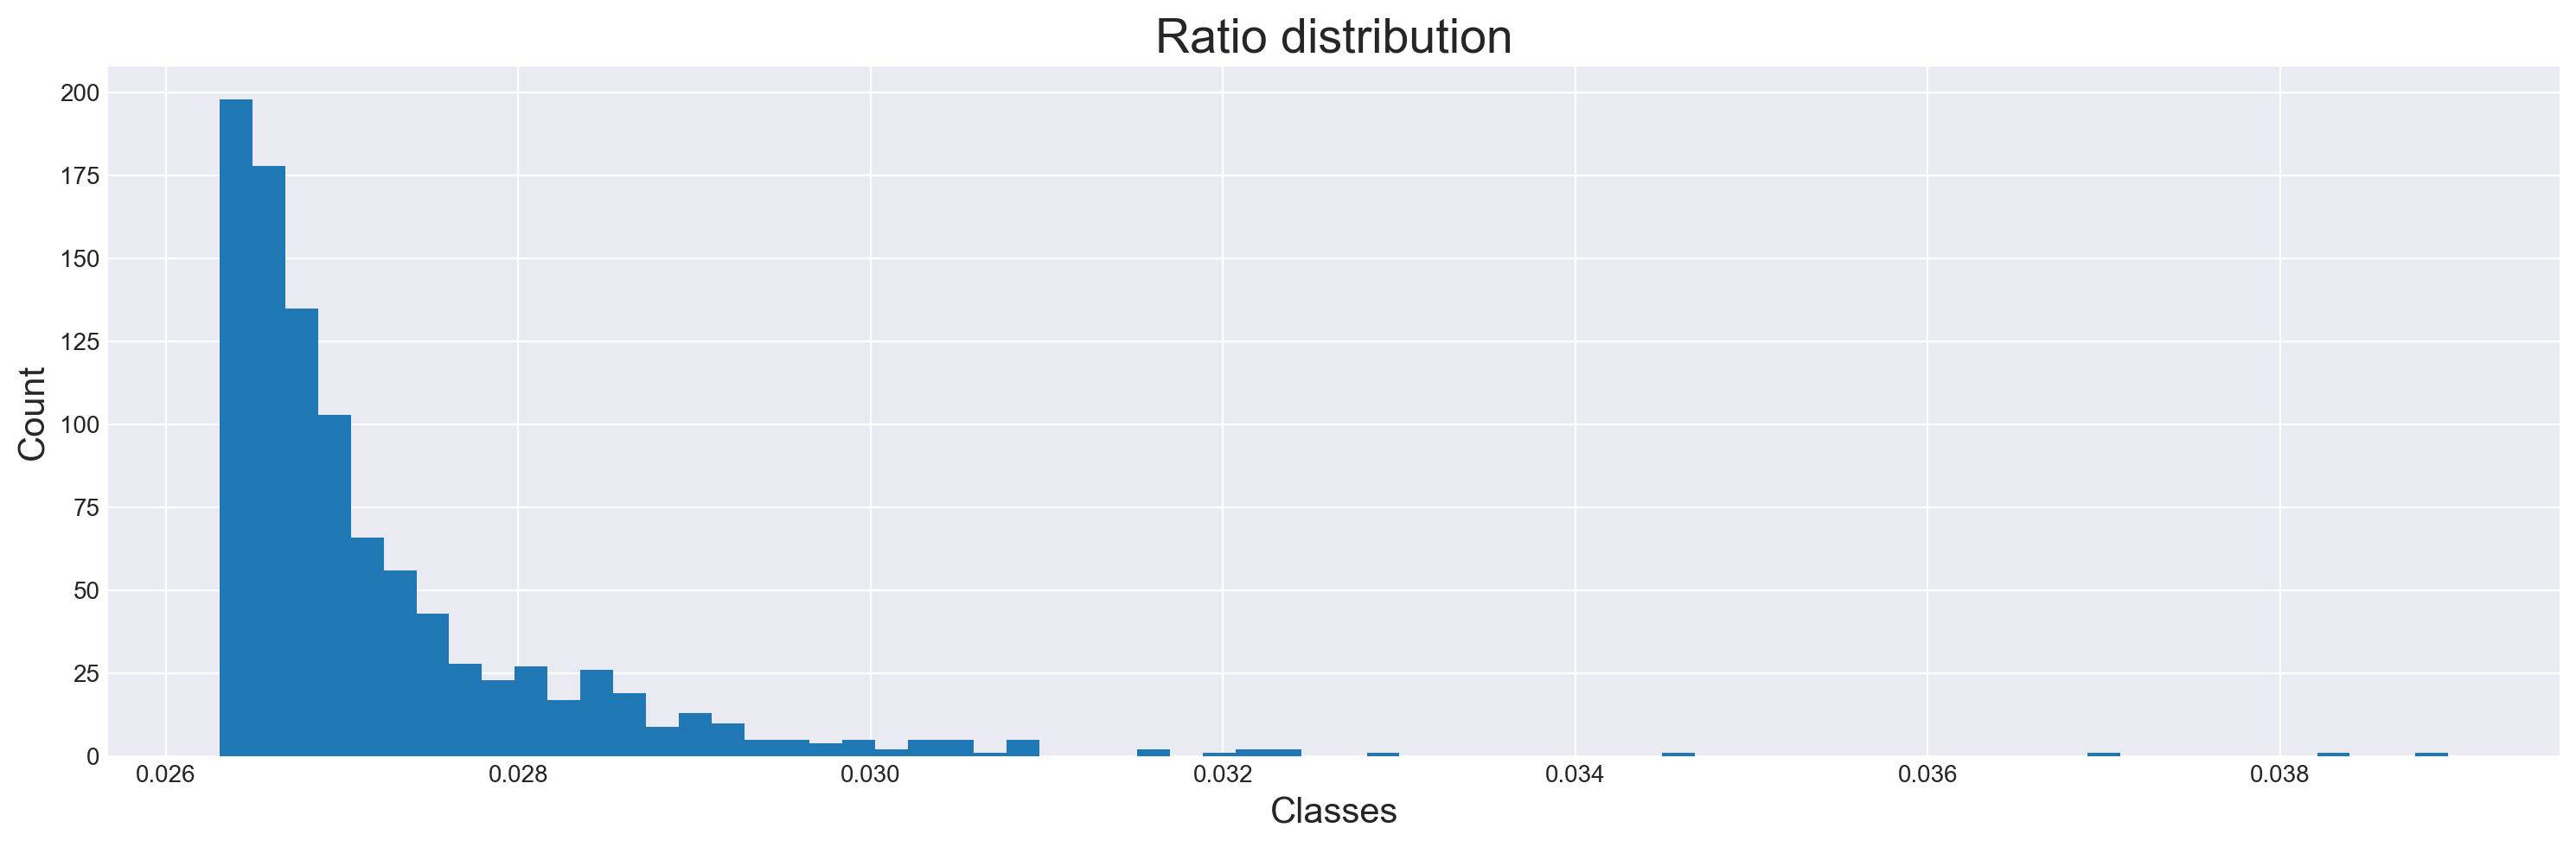

In [127]:
plt.hist(expenses_2025_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

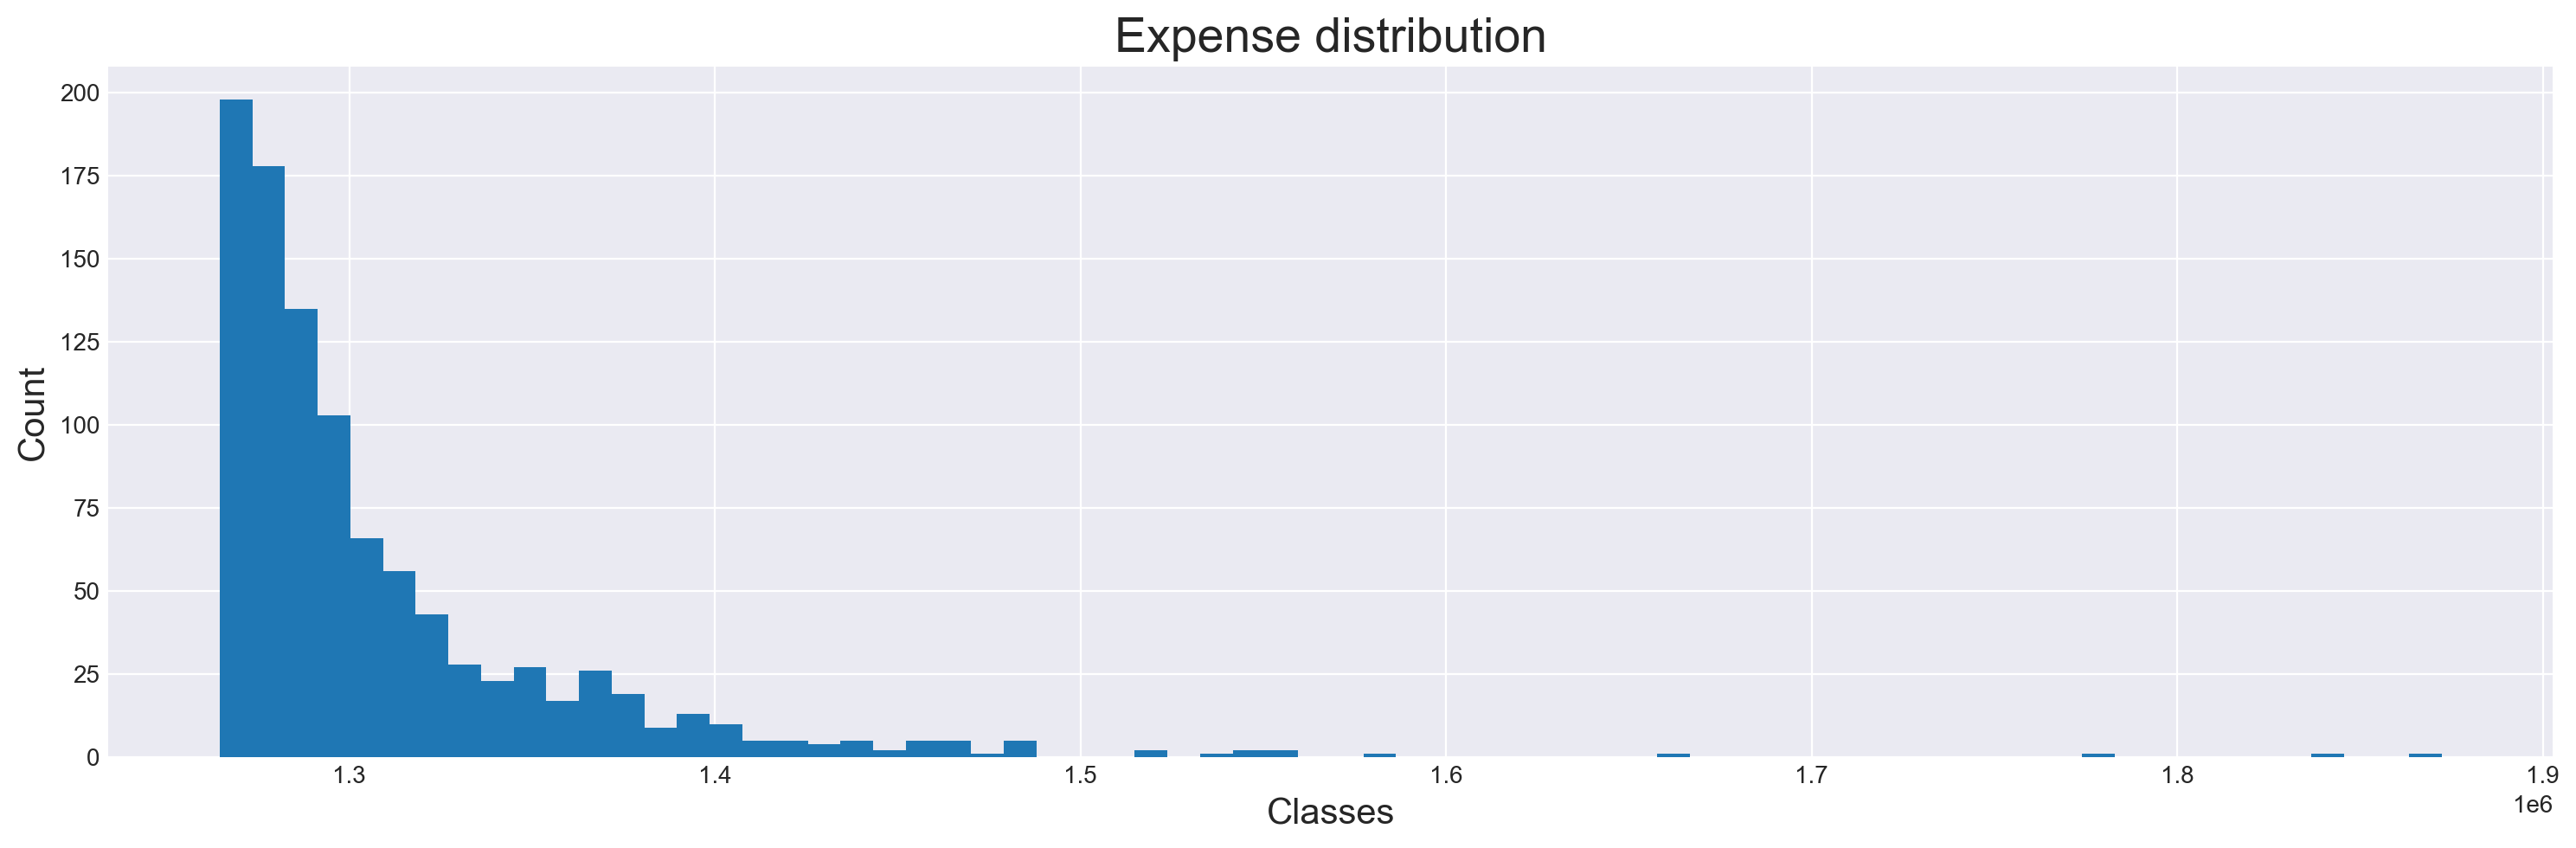

In [128]:
plt.hist(expenses_2025_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [129]:
# 2026 expenses

In [130]:
expenses_2026 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2026]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2026,),'Price'].values[0] * 12,fund_amount = df_2026_lc.Loss.values[0])

In [131]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2026_dict = expenses_2026.montecarlo(alpha = 5,number_of_replications = 1000)

$$    
\begin{eqnarray} \label{eq:8}
    Expense \quad ratio = \frac{Total \quad fund \quad costs}{Total \quad fund \quad assets}
  \end{eqnarray} $$

In [132]:
# expense ratio for gross rate calculation
or_2026 = expenses_2026_dict['optimal_ratio']
or_2026

0.029679347636682302

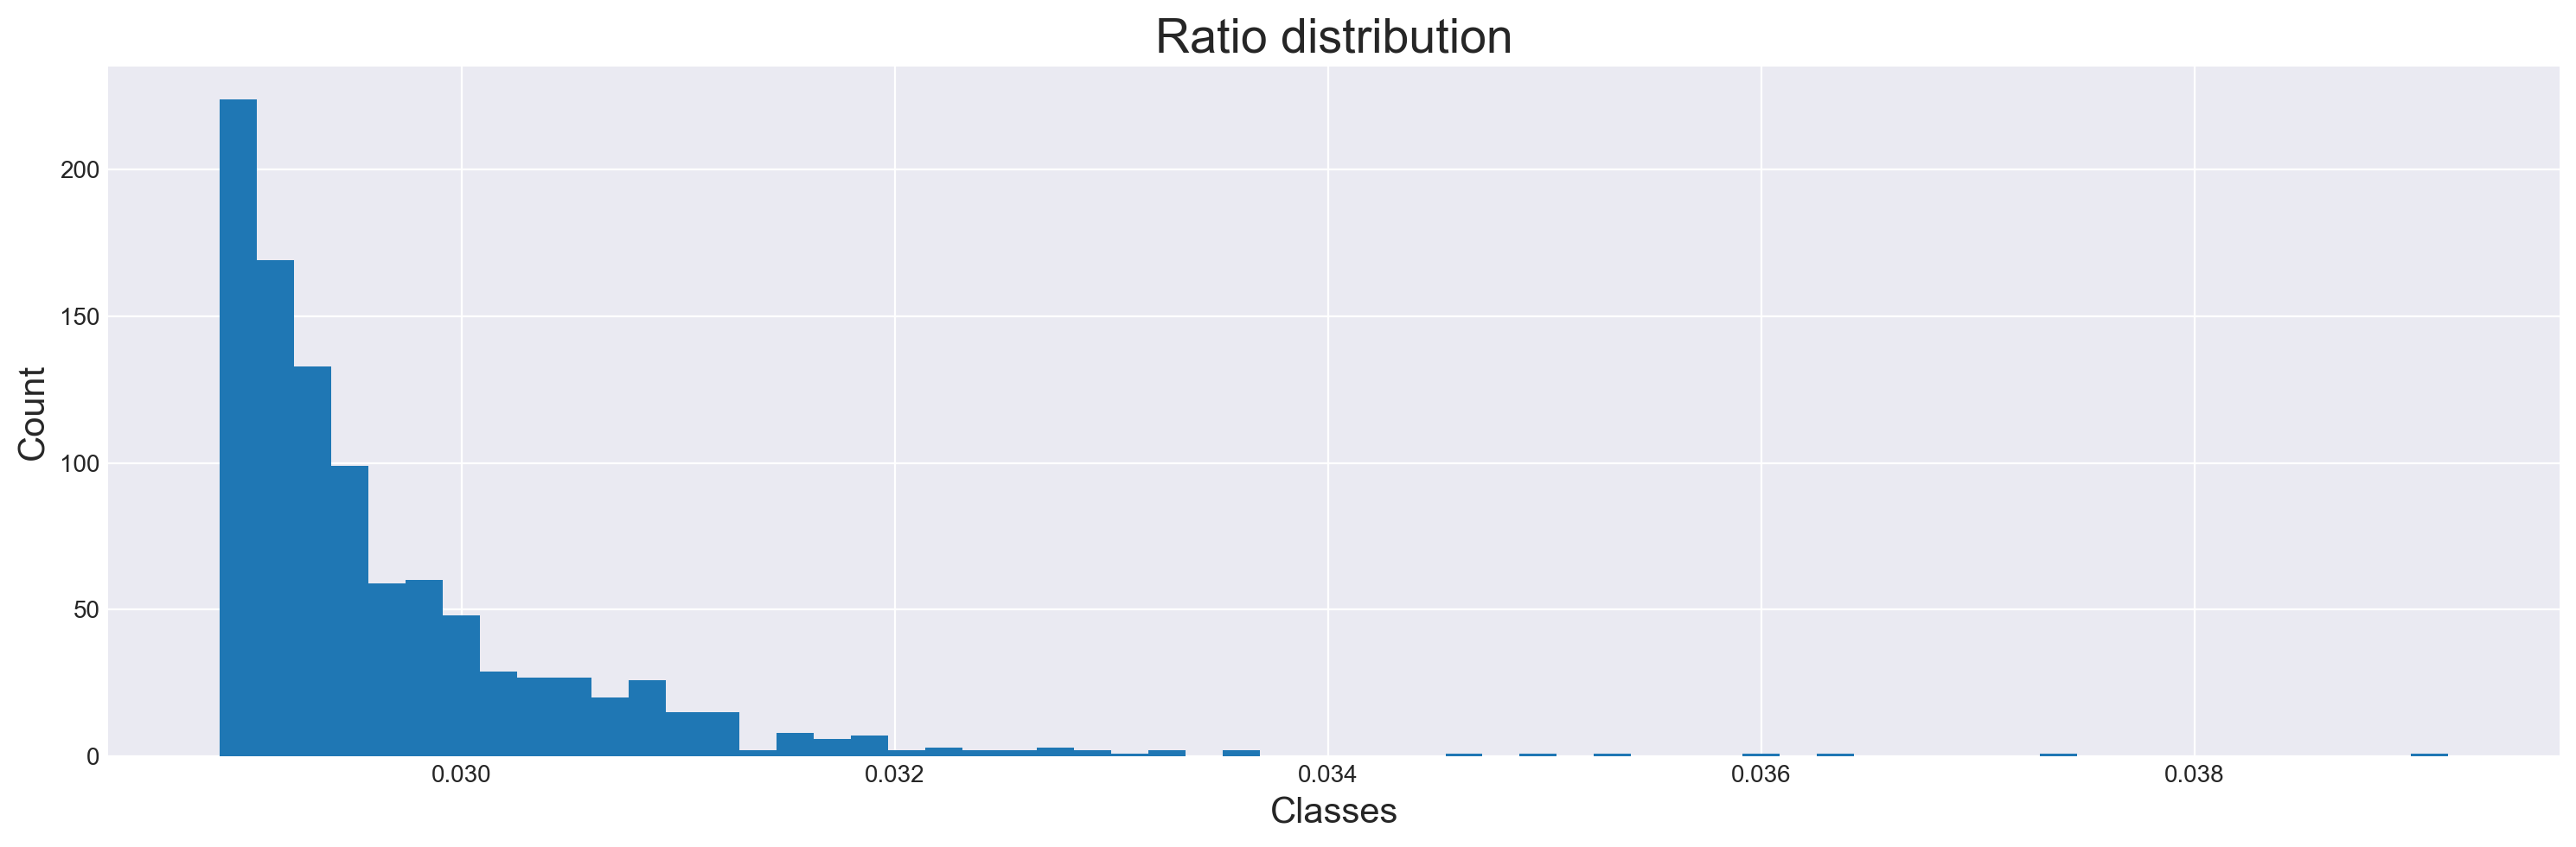

In [133]:
plt.hist(expenses_2026_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

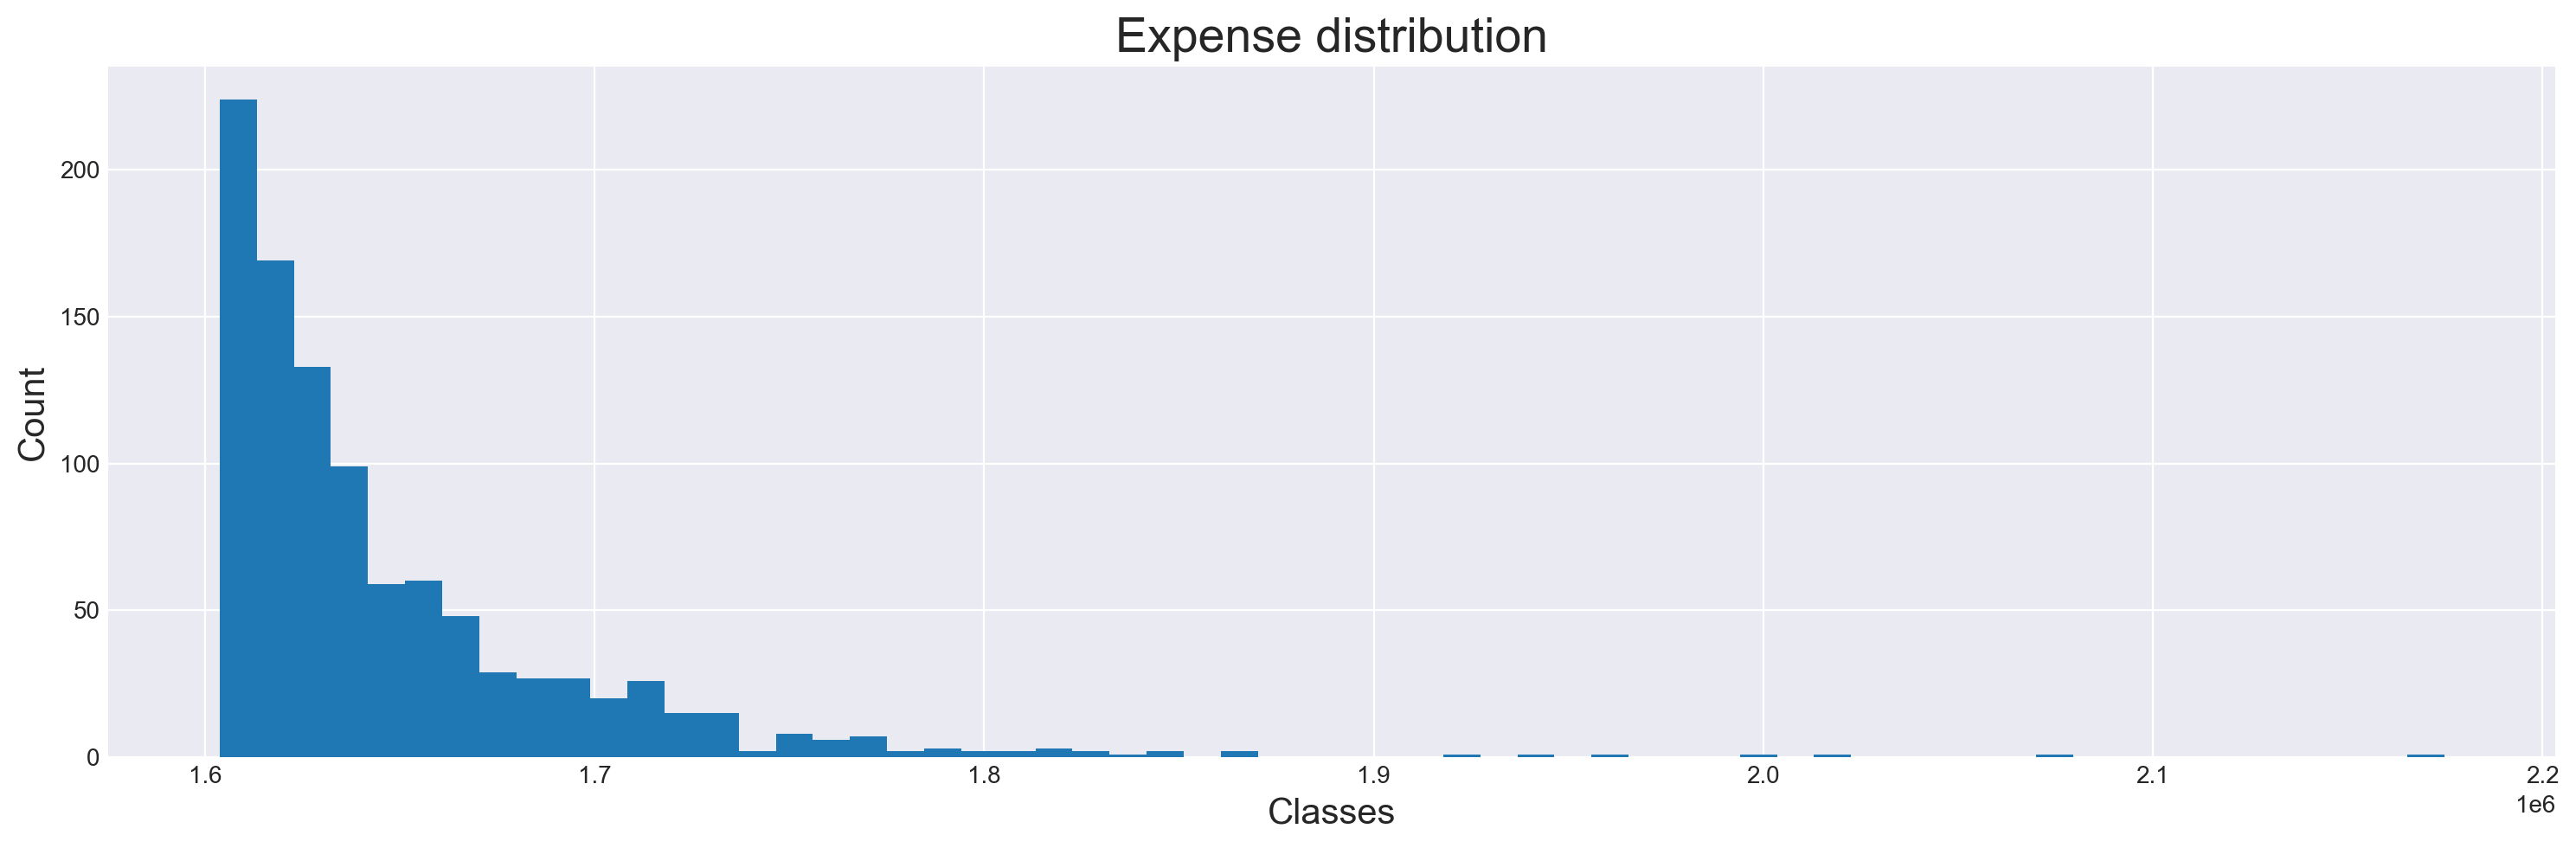

In [134]:
plt.hist(expenses_2026_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [135]:
# 2027 expenses

In [136]:
expenses_2027 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2027]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2027,),'Price'].values[0] * 12,fund_amount = df_2027_lc.Loss.values[0])

In [137]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2027_dict = expenses_2027.montecarlo(alpha = 5,number_of_replications = 1000)

$$       \begin{eqnarray}
    Expense \quad ratio = \frac{Total \quad fund \quad costs}{Total \quad fund \quad assets}
  \end{eqnarray} $$

In [138]:
# expense ratio for gross rate calculation
or_2027 = expenses_2027_dict['optimal_ratio']
or_2027

0.03227032499975726

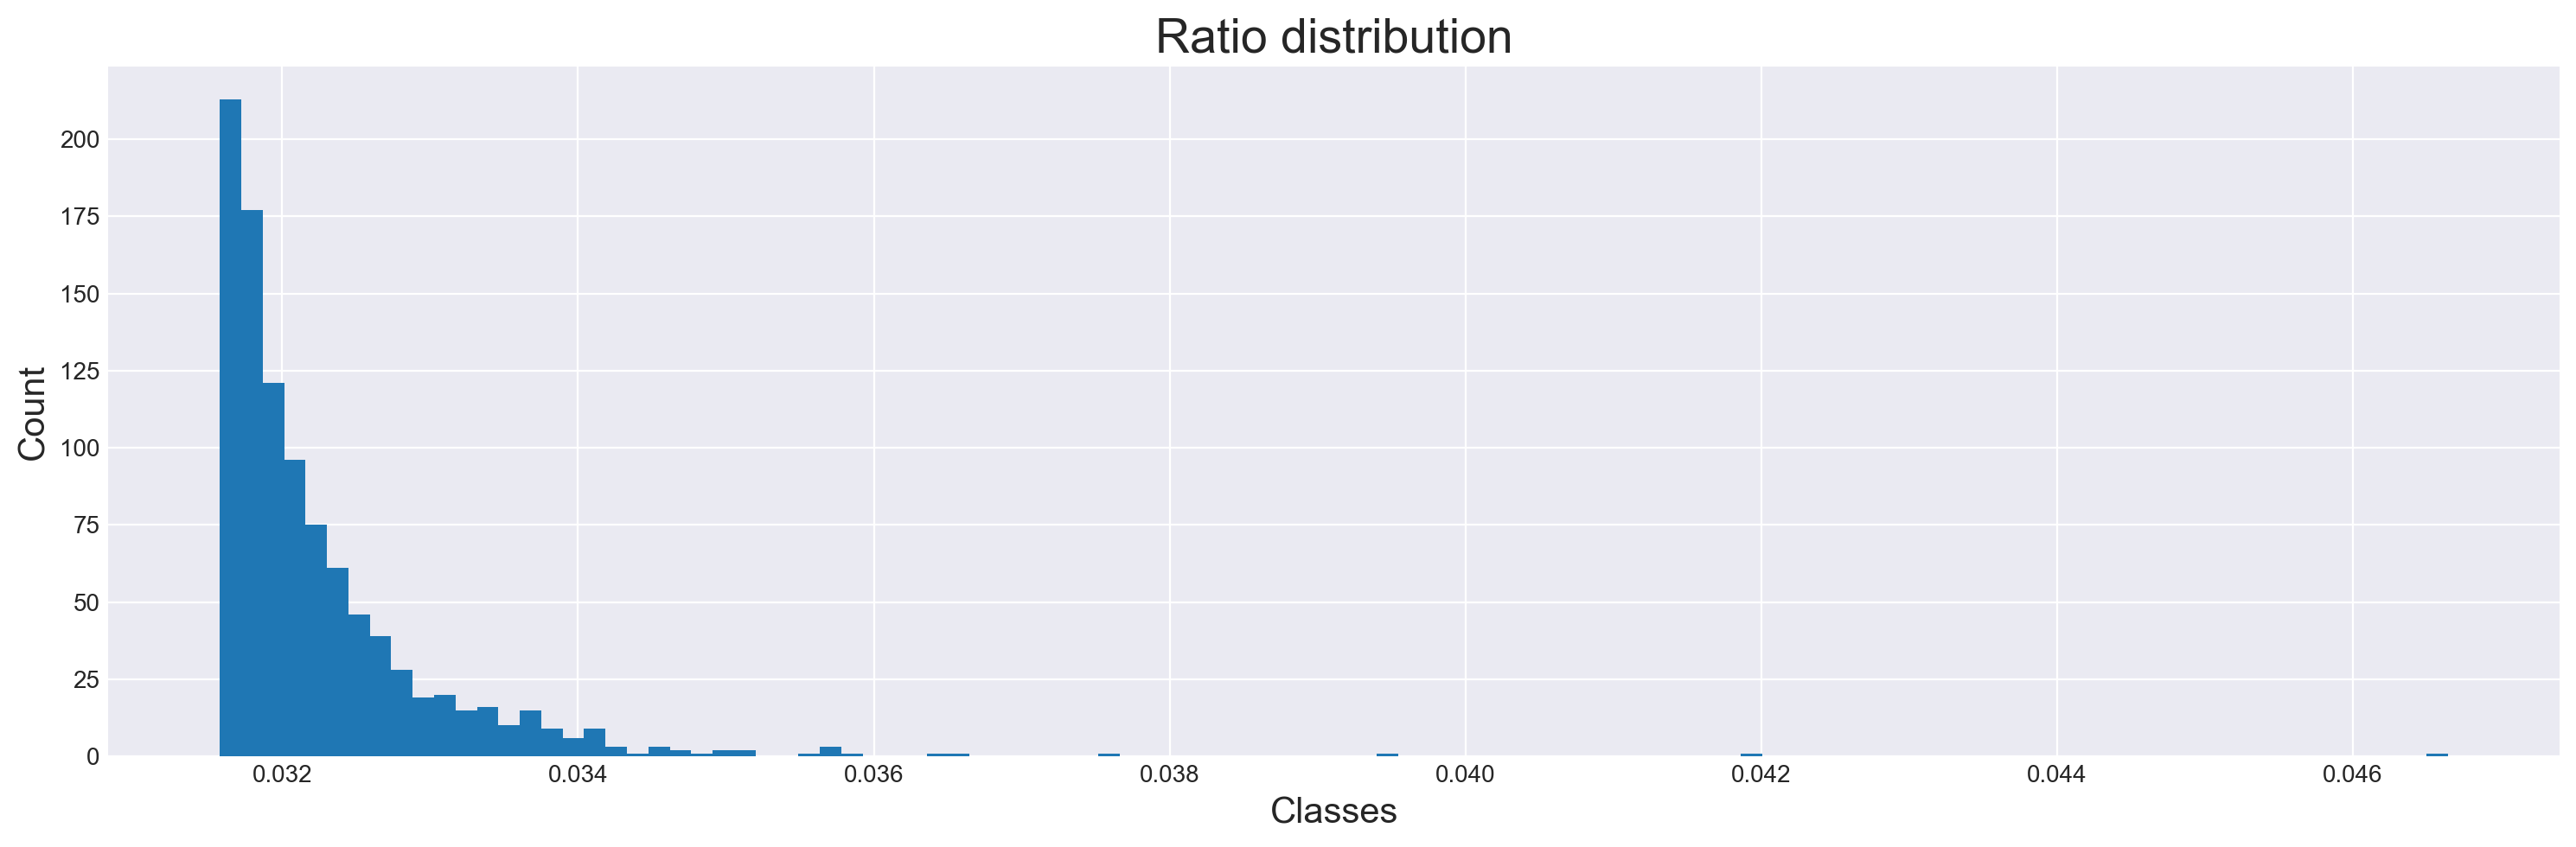

In [139]:
plt.hist(expenses_2027_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

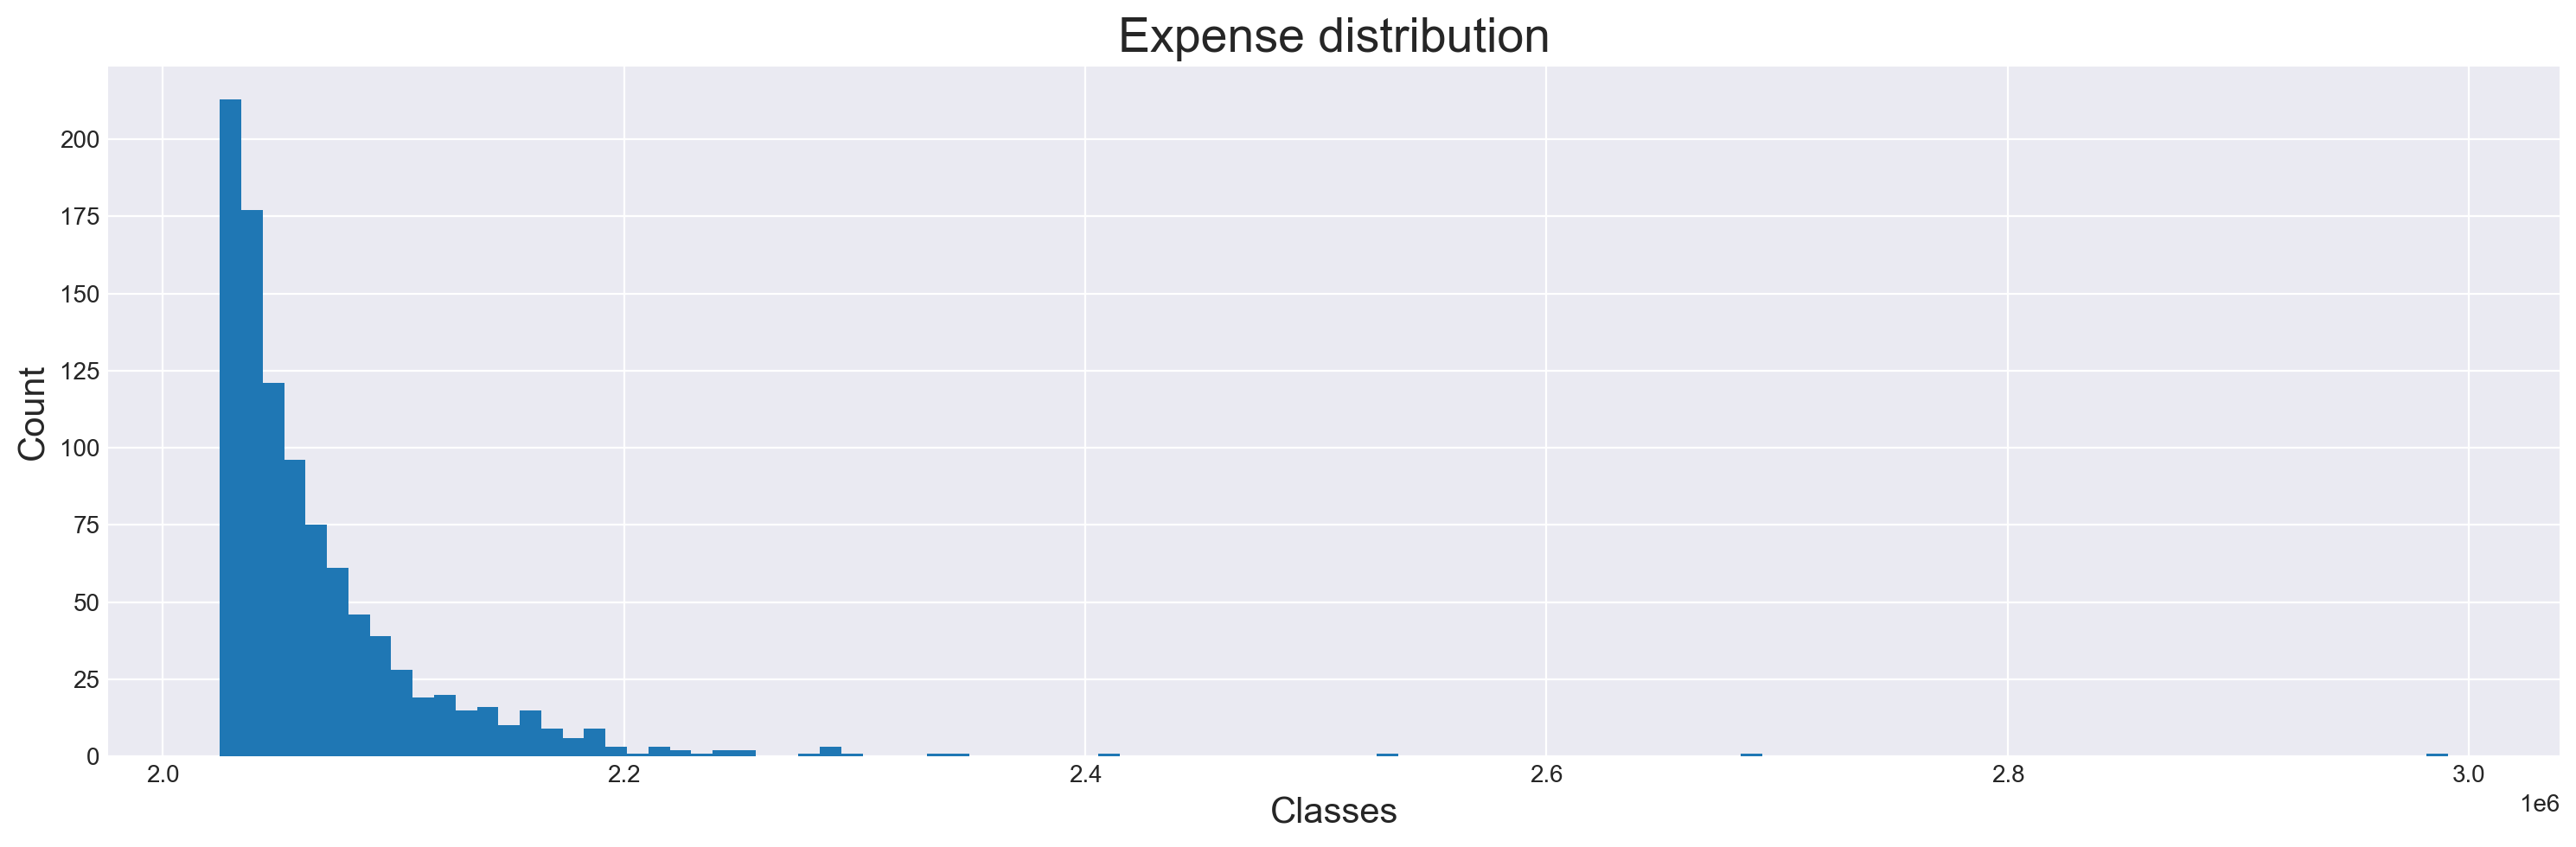

In [140]:
plt.hist(expenses_2027_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [141]:
# 2028 expenses

In [142]:
expenses_2028 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2028]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2028,),'Price'].values[0] * 12,fund_amount = df_2028_lc.Loss.values[0])

In [143]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2028_dict = expenses_2028.montecarlo(alpha = 5,number_of_replications = 1000)

$$       \begin{eqnarray}
    Expense \quad ratio = \frac{Total \quad fund \quad costs}{Total \quad fund \quad assets}
  \end{eqnarray} $$

In [144]:
# Expense ratio for gross rate calculation
or_2028 = expenses_2028_dict['optimal_ratio']
or_2028

0.035023970173463016

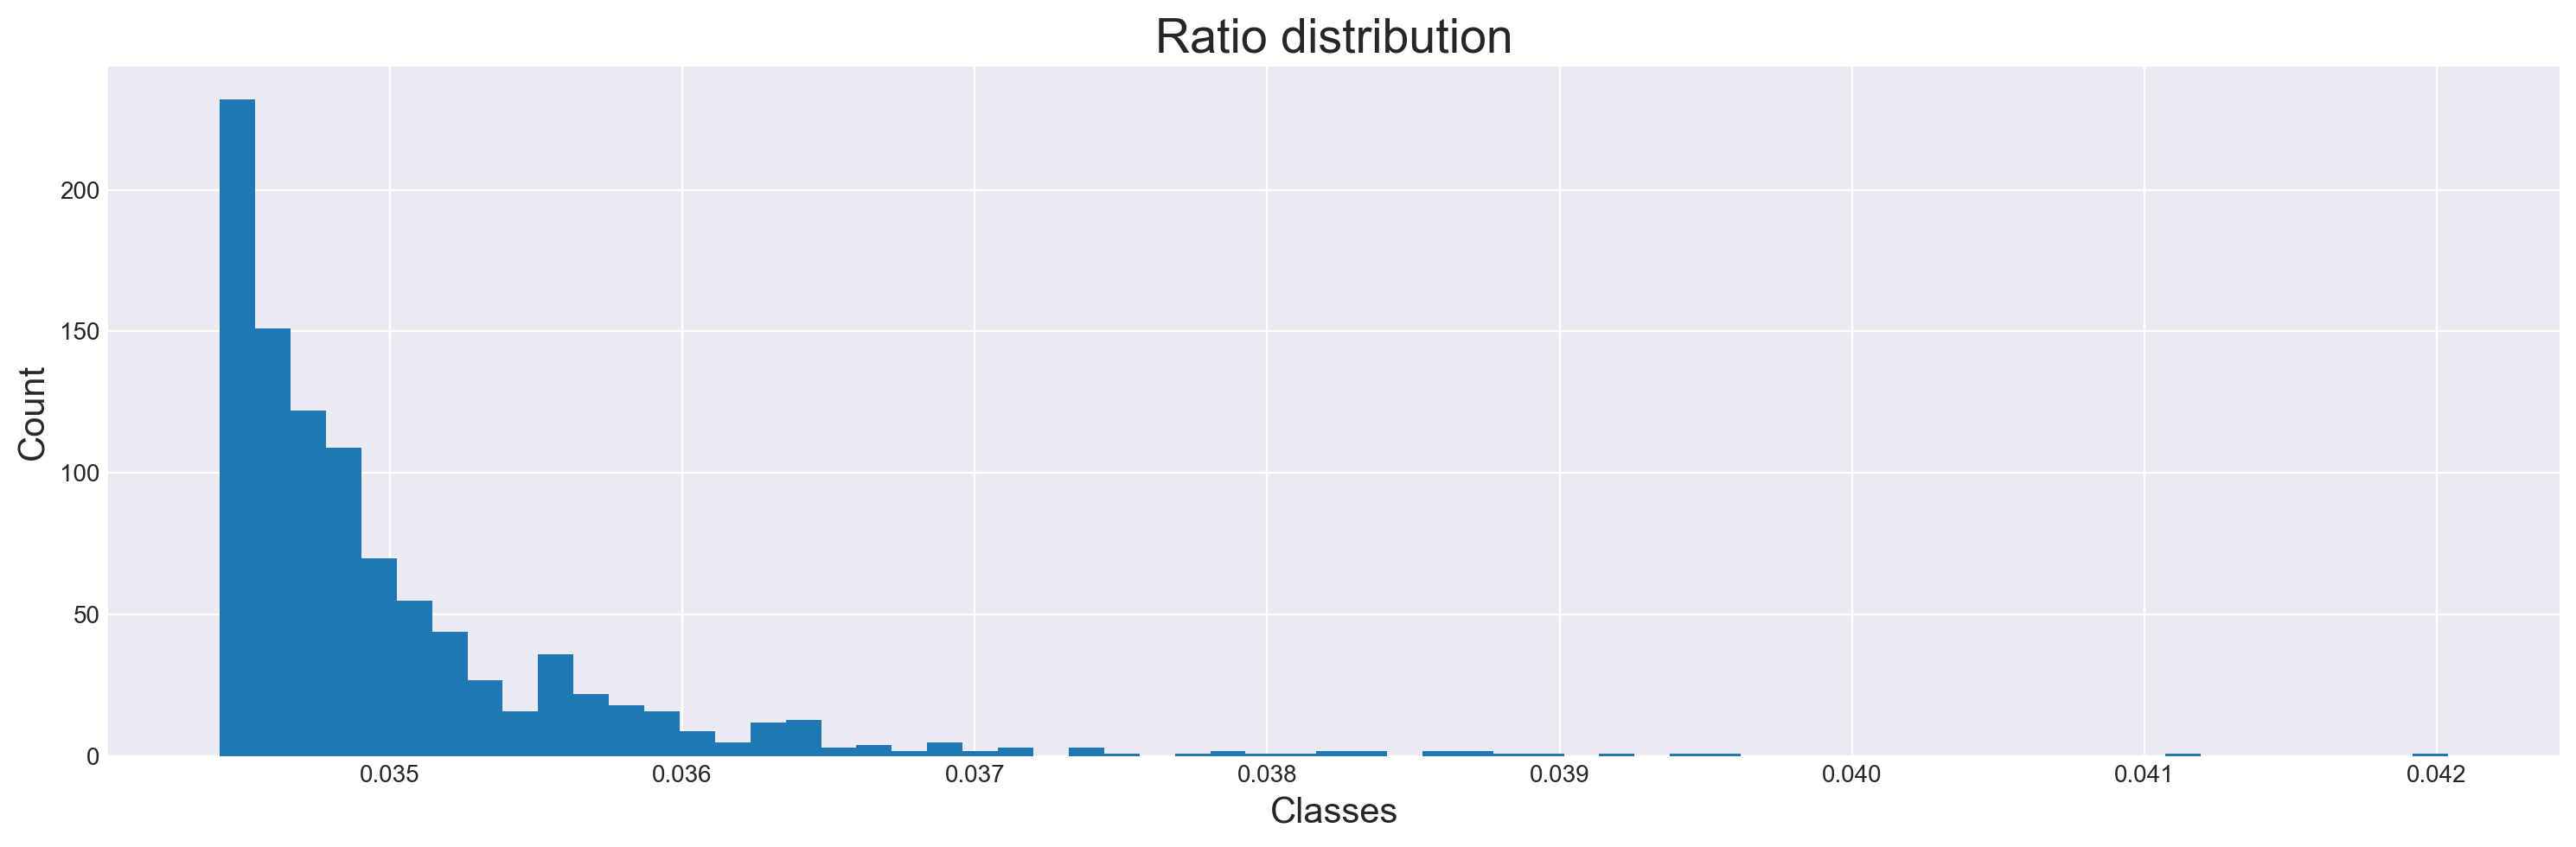

In [145]:
plt.hist(expenses_2028_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

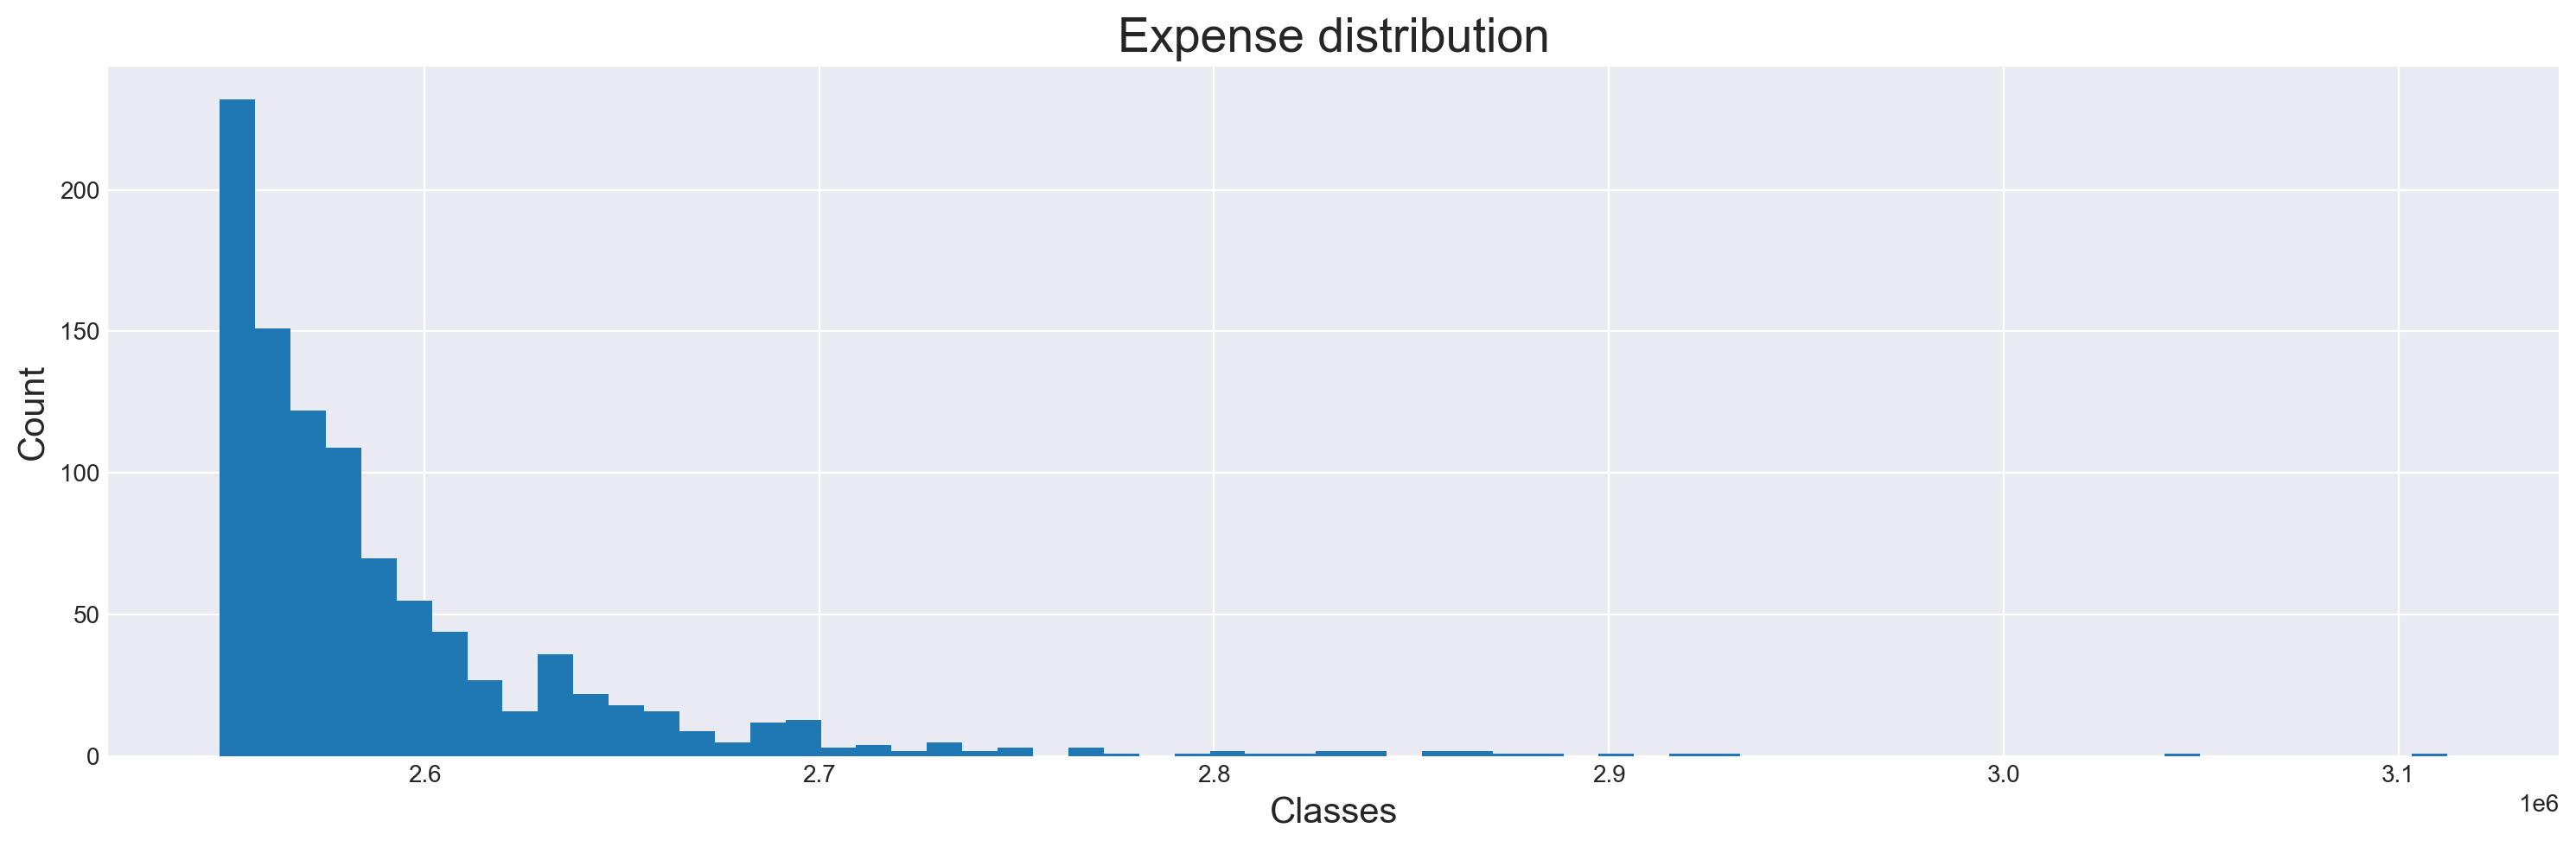

In [146]:
plt.hist(expenses_2028_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [147]:
# 2029 expenses

In [148]:
expenses_2029 = Expenses(mean_expenses = cost_by_year[cost_by_year.index == 2029]['Cost'].values[0],variance_expenses = std * exp_price_refined.loc[exp_price_refined.index == (2029,),'Price'].values[0] * 12,fund_amount = df_2029_lc.Loss.values[0])

In [149]:
# calculating optimal expense values through montecarlo simulation with an assumption that expenses has a pareto distribution
expenses_2029_dict = expenses_2029.montecarlo(alpha = 5,number_of_replications = 1000)

$$       \begin{eqnarray}
    Expense \quad ratio = \frac{Total \quad fund \quad costs}{Total \quad fund \quad assets}
  \end{eqnarray} $$

In [150]:
# Expense ration fro gross rate calculation
or_2029 = expenses_2029_dict['optimal_ratio']
or_2029

0.03795758802811364

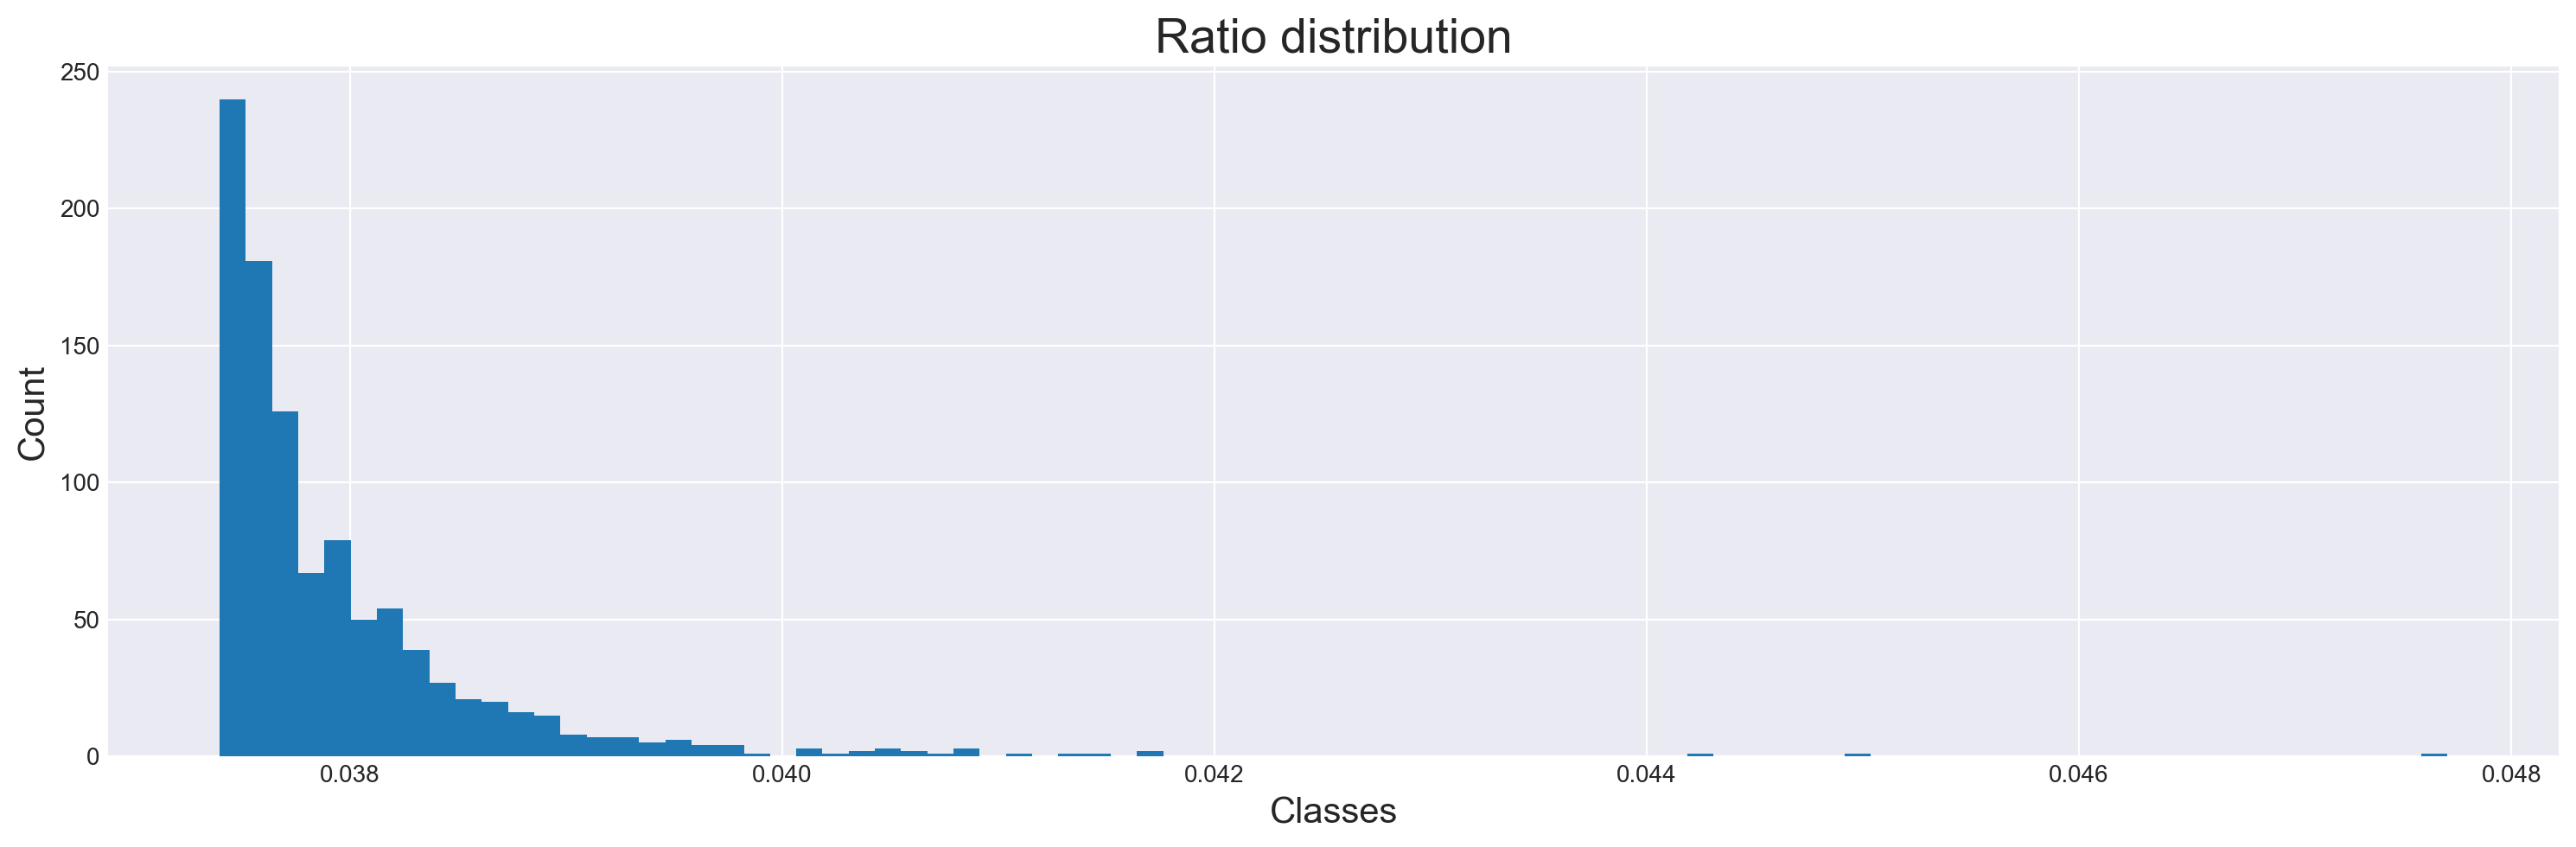

In [151]:
plt.hist(expenses_2029_dict['ratio_output'],bins = 'auto')
plt.title('Ratio distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

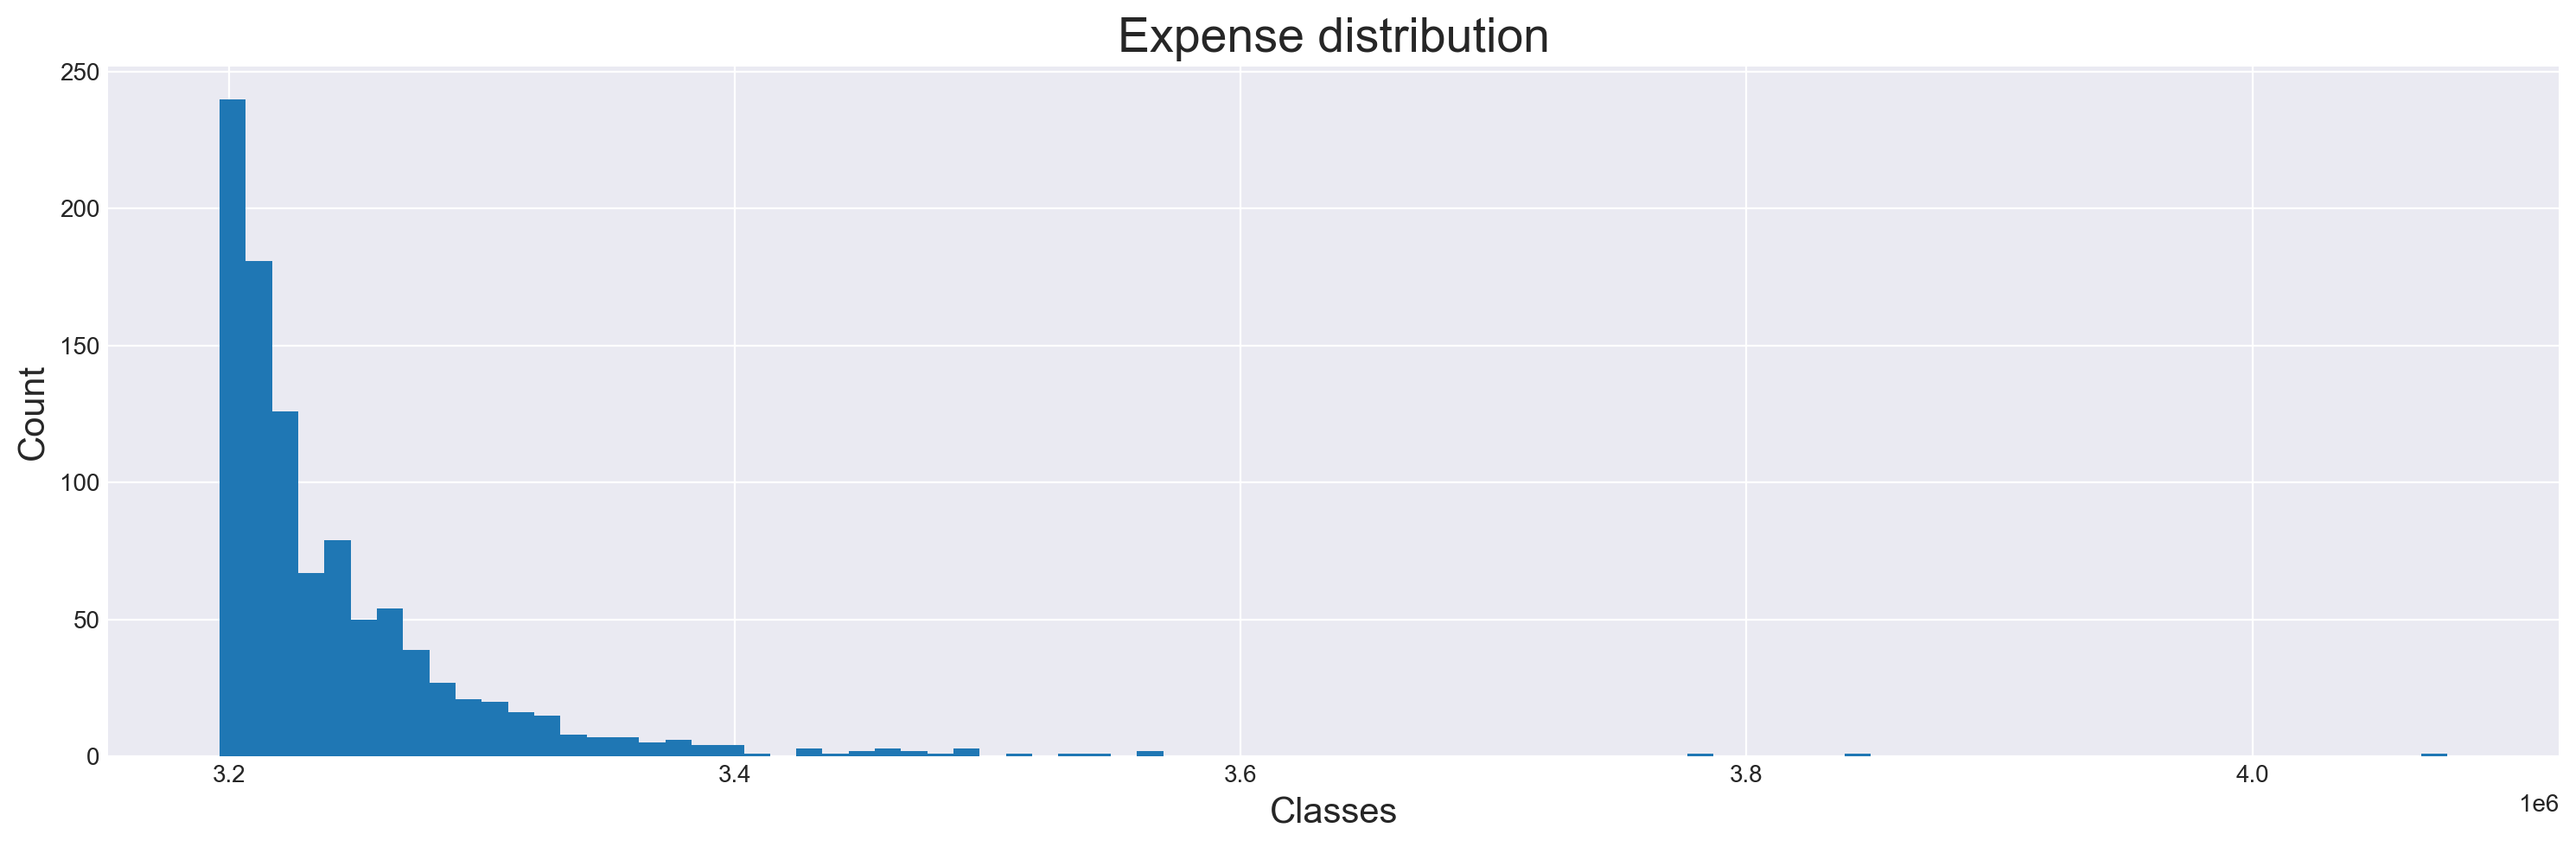

In [152]:
plt.hist(expenses_2029_dict['expense_output'],bins = 'auto')
plt.title('Expense distribution',size = 20)
plt.xlabel('Classes',size = 15)
plt.ylabel('Count',size = 15)
plt.show()

In [153]:
# defining expense ratio dataframe
optimal_ratio_df = pd.DataFrame({'Ratio':[or_2025,or_2026,or_2027,or_2028,or_2029]},index = [2025,2026,2027,2028,2029])

In [154]:
optimal_ratio_df

,Ratio
2025,0.027236
2026,0.029679
2027,0.032270
2028,0.035024
2029,0.037958


In [155]:
pure_premium_df

,Pure premium
Year,
2025,22.381998
2026,25.198394
2027,28.370370
2028,31.944537
2029,35.973275


In [156]:
# defining gross rate dataframe
gross_rate_df = optimal_ratio_df.join([pure_premium_df])

In [157]:
gross_rate_df

,Ratio,Pure premium
2025,0.027236,22.381998
2026,0.029679,25.198394
2027,0.032270,28.370370
2028,0.035024,31.944537
2029,0.037958,35.973275


$$   \begin{eqnarray} \label{eq:7}
    Gross \quad rate = \frac{pure \quad premium}{1 - expense \quad ratio}
  \end{eqnarray} $$


In [158]:
# defining gross rate column
gross_rate_df['Gross rate'] = gross_rate_df.apply(lambda col: Premium.gross_rate(col['Pure premium'],col['Ratio']),axis = 'columns')

In [159]:
gross_rate_df

,Ratio,Pure premium,Gross rate
2025,0.027236,22.381998,23.008669
2026,0.029679,25.198394,25.969142
2027,0.032270,28.370370,29.316421
2028,0.035024,31.944537,33.103969
2029,0.037958,35.973275,37.392608


In [160]:
exposures_ref = exposures
exposures_ref.index = [2025,2026,2027,2028,2029]
exposures_ref

,Exposures,Exposures shift()
2025,2203399,2147596.0
2026,2260115,2203399.0
2027,2317627,2260115.0
2028,2375855,2317627.0
2029,2434788,2375855.0


In [161]:
gross_rate_df = gross_rate_df.join([exposures_ref])

In [162]:
gross_rate_df

,Ratio,Pure premium,Gross rate,Exposures,Exposures shift()
2025,0.027236,22.381998,23.008669,2203399,2147596.0
2026,0.029679,25.198394,25.969142,2260115,2203399.0
2027,0.032270,28.370370,29.316421,2317627,2260115.0
2028,0.035024,31.944537,33.103969,2375855,2317627.0
2029,0.037958,35.973275,37.392608,2434788,2375855.0


  
$$ Gross \quad premium =( gross \quad rate) * (Exposures)$$ 

In [163]:
# defining total gross rates column
gross_rate_df['Total gross rates'] = gross_rate_df.apply(lambda col: Premium.gross_premium(col['Gross rate'],col['Exposures shift()']),axis = 'columns')

In [164]:
gross_rate_df

,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Total gross rates
2025,0.027236,22.381998,23.008669,2203399,2147596.0,4.941332e+07
2026,0.029679,25.198394,25.969142,2260115,2203399.0,5.722038e+07
2027,0.032270,28.370370,29.316421,2317627,2260115.0,6.625848e+07
2028,0.035024,31.944537,33.103969,2375855,2317627.0,7.672265e+07
2029,0.037958,35.973275,37.392608,2434788,2375855.0,8.883941e+07


In [165]:
Total_premium = gross_rate_df

<h2 style = 'background-color:teal;padding:10px;color:white;border-radius:10px;text-align:center;margin-left:150px;margin-right:170px;'> Tax calculation </h2>

In [173]:
# loading real interest rate
real_interest = pd.read_excel('realInterest.xls')

In [174]:
real_interest

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66
0,Last Updated Date,2023-10-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.000000,1962.000000,1963.000000,1964.000000,1965.000000,...,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000
3,Aruba,ABW,Real interest rate (%),FR.INR.RINR,NaN,NaN,NaN,NaN,NaN,NaN,...,10.699324,4.851601,4.358079,8.406540,8.197718,5.306747,2.624635,13.122279,NaN,NaN
4,Africa Eastern and Southern,AFE,Real interest rate (%),FR.INR.RINR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,Kosovo,XKX,Real interest rate (%),FR.INR.RINR,NaN,NaN,NaN,NaN,NaN,NaN,...,11.426638,8.871489,7.665605,6.615972,6.364710,5.079008,NaN,NaN,NaN,NaN
265,"Yemen, Rep.",YEM,Real interest rate (%),FR.INR.RINR,NaN,NaN,NaN,NaN,NaN,NaN,...,11.788755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,South Africa,ZAF,Real interest rate (%),FR.INR.RINR,NaN,5.200152,6.013274,2.423273,3.667879,3.800071,...,2.509245,3.567028,3.667743,3.278252,4.647315,6.108760,5.243711,1.907151,0.774484,3.557564
267,Zambia,ZMB,Real interest rate (%),FR.INR.RINR,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.191720,5.821128,6.179216,1.715079,2.070262,2.215865,2.469674,-3.749081,NaN,NaN


In [175]:
# data cleaning

In [176]:
real_interest = real_interest.iloc[2::,::]

In [177]:
real_interest.columns = real_interest.iloc[0].values

In [178]:
real_interest = real_interest.loc[real_interest['Country Name'] == 'Malawi']

In [179]:
real_interest = real_interest.T

In [180]:
real_interest.dropna(inplace = True)

In [181]:
real_interest = real_interest.iloc[4::]

In [182]:
real_interest.columns = ['Real interest (%)']

In [183]:
real_interest.index = [int(i) for i in real_interest.index]

In [184]:
real_interest.head()

,Real interest (%)
1981,1.799105
1982,8.058069
1983,6.38638
1984,3.305735
1985,8.669878


In [185]:
real_interest.tail()

,Real interest (%)
2018,24.650079
2019,16.658529
2020,13.895988
2021,13.254763
2022,2.839456


In [186]:
real_interest

,Real interest (%)
1981,1.799105
1982,8.058069
1983,6.38638
1984,3.305735
1985,8.669878
1986,4.837239
1987,2.378377
1988,-6.744743
1989,0.400389
1990,9.343061


In [187]:
# loading real interest rate
real_interest = pd.read_excel('realInterest.xls')
        
real_interest = real_interest.iloc[2::,::]
real_interest.columns = real_interest.iloc[0].values
real_interest = real_interest.loc[real_interest['Country Name'] == 'Malawi']
real_interest = real_interest.T
real_interest.dropna(inplace = True)
real_interest = real_interest.iloc[4::]
real_interest.columns = ['Real interest (%)']
real_interest.index = [int(i) for i in real_interest.index]

In [188]:
real_interest.to_csv('realInte.csv')

In [189]:
# loading inflation data
inflation_rate = pd.read_excel('infla.xls')

In [190]:
inflation_rate

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66
0,Last Updated Date,2023-10-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.000000,1961.000000,1962.000000,1963.00000,1964.000000,1965.000000,...,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000
3,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
4,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.526577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,Kosovo,XKX,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,1.767324,0.428958,-0.536929,0.273169,1.488234,1.053798,2.675992,0.198228,3.353691,11.580510
265,"Yemen, Rep.",YEM,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,10.968442,8.104726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,South Africa,ZAF,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.288859,2.102374,1.246285,1.33797,2.534973,4.069029,...,5.784469,6.129838,4.540642,6.571396,5.184247,4.517165,4.120246,3.210036,4.611672,7.039727
267,Zambia,ZMB,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.977676,7.806876,10.110593,17.869730,6.577312,7.494572,9.150316,15.733060,22.020768,10.993204


In [191]:
# data cleaning

In [192]:
inflation_rate = inflation_rate.iloc[2::,::]

In [193]:
inflation_rate.columns = inflation_rate.iloc[0].values

In [194]:
inflation_rate = inflation_rate.loc[inflation_rate['Country Name'] == 'Malawi']

In [195]:
inflation_rate = inflation_rate.T

In [196]:
inflation_rate.dropna(inplace = True)

In [197]:
inflation_rate = inflation_rate.iloc[4::]

In [198]:
inflation_rate.columns = ['Inflation rate (%)']

In [199]:
inflation_rate.index = [int(i) for i in inflation_rate.index]

In [200]:
inflation_rate.head()

,Inflation rate (%)
1981,11.814698
1982,9.821162
1983,13.502511
1984,20.026303
1985,10.518976


In [201]:
inflation_rate.tail()

,Inflation rate (%)
2018,12.420178
2019,9.370836
2020,8.625515
2021,9.330144
2022,20.95397


In [202]:
inflation_rate.to_csv('inflationRate.csv')

In [203]:
# joining real interest and inflation dataframe
rates = real_interest.join([inflation_rate])

In [204]:
rates.head()

,Real interest (%),Inflation rate (%)
1981,1.799105,11.814698
1982,8.058069,9.821162
1983,6.38638,13.502511
1984,3.305735,20.026303
1985,8.669878,10.518976


In [205]:
rates.tail()

,Real interest (%),Inflation rate (%)
2018,24.650079,12.420178
2019,16.658529,9.370836
2020,13.895988,8.625515
2021,13.254763,9.330144
2022,2.839456,20.95397


In [206]:
class compute_rates():
    
    def nominal_interest_rate(real_interest_rate : float,inflation_rate : float):

        return real_interest_rate + inflation_rate
    
    def real_interest_rate(nominal_interest_rate : float,inflation_rate : float):

        return nominal_interest_rate - inflation_rate
    
    def inflation_rate(real_interest_rate : float,nominal_interest_rate : float):

        return nominal_interest_rate - real_interest_rate
    
    def effective_interest_rate(nominal_interest_rate : float, number_of_compounding_periods : int):

        return ((1 + nominal_interest_rate/number_of_compounding_periods)**number_of_compounding_periods) -1

In [207]:
class vasicek_model():
   
    def __init__(self,data : list,number_of_prediction_points : int):
        self.data = data
        self.number_of_prediction_points = number_of_prediction_points
        self.mean_reversion = None
        self.drift = None
        self.volatility = None
        self.interest_rate_now = self.data[len(self.data)-1]
        self.ols_model = None
        
    def fit(self):
        
        import statsmodels.formula.api as sm
        import pandas as pd
        
        rates = pd.DataFrame({'Rates':self.data})
        rates['Diff'] = rates.diff()
        rates['Lag'] = rates['Rates'].shift()
        
        model =sm.ols('Diff~Lag',data = rates)
        results = model.fit()
        
        self.ols_model = results
        
        self.mean_reversion = abs(results.params.Lag)
        self.drift = (results.params.Intercept) / self.mean_reversion
        self.volatility = results.mse_resid ** (1/2)
    
    def expectation(self):
        
        import math
        
        forecasts_rt = []
        
        for i in list(range(1,self.number_of_prediction_points + 1)):
            expected_rate = self.interest_rate_now * math.exp(-self.mean_reversion*i) + self.drift*(1 - math.exp(-self.mean_reversion*i))
            forecasts_rt.append(expected_rate)
            
        return forecasts_rt
    
    def variance(self):
            
        import math
        
        variance_rt = []
        
        for i in list(range(1,self.number_of_prediction_points + 1)):
            rate_dev = ((self.volatility ** 2)/2*self.mean_reversion) * (1 - math.exp(-2 * self.mean_reversion*i))
            variance_rt.append(rate_dev)
        
        return variance_rt
    
    def ols_model_results(self):
 
        print(self.ols_model.summary())

$$ Norminal \quad rate = Real \quad interest \quad rate + Inflation \quad rate $$

In [208]:
# defining norminal interest rate column
rates['Norminal rate (%)'] = rates.apply(lambda col: compute_rates.nominal_interest_rate(col['Real interest (%)'],col['Inflation rate (%)']),axis = 'columns')

In [209]:
rates.head()

,Real interest (%),Inflation rate (%),Norminal rate (%)
1981,1.799105,11.814698,13.613802
1982,8.058069,9.821162,17.879232
1983,6.38638,13.502511,19.888891
1984,3.305735,20.026303,23.332038
1985,8.669878,10.518976,19.188854


In [210]:
rates.tail()

,Real interest (%),Inflation rate (%),Norminal rate (%)
2018,24.650079,12.420178,37.070258
2019,16.658529,9.370836,26.029365
2020,13.895988,8.625515,22.521503
2021,13.254763,9.330144,22.584908
2022,2.839456,20.95397,23.793426


$$    \begin{eqnarray} 
        Effective \quad annual \quad rate (EAR) = (1 + \frac{nominal\quad rate}{\pi})^{\pi} - 1 
    \end{eqnarray}$$

In [211]:
# defining effective rate column
rates['Effective rate'] = rates.apply(lambda col: compute_rates.effective_interest_rate(col['Norminal rate (%)']/100,12),axis = 'columns')

In [212]:
rates.head()

,Real interest (%),Inflation rate (%),Norminal rate (%),Effective rate
1981,1.799105,11.814698,13.613802,0.144962
1982,8.058069,9.821162,17.879232,0.194196
1983,6.38638,13.502511,19.888891,0.218059
1984,3.305735,20.026303,23.332038,0.259961
1985,8.669878,10.518976,19.188854,0.209698


In [213]:
rates.tail()

,Real interest (%),Inflation rate (%),Norminal rate (%),Effective rate
2018,24.650079,12.420178,37.070258,0.440647
2019,16.658529,9.370836,26.029365,0.293706
2020,13.895988,8.625515,22.521503,0.249980
2021,13.254763,9.330144,22.584908,0.250758
2022,2.839456,20.95397,23.793426,0.265676


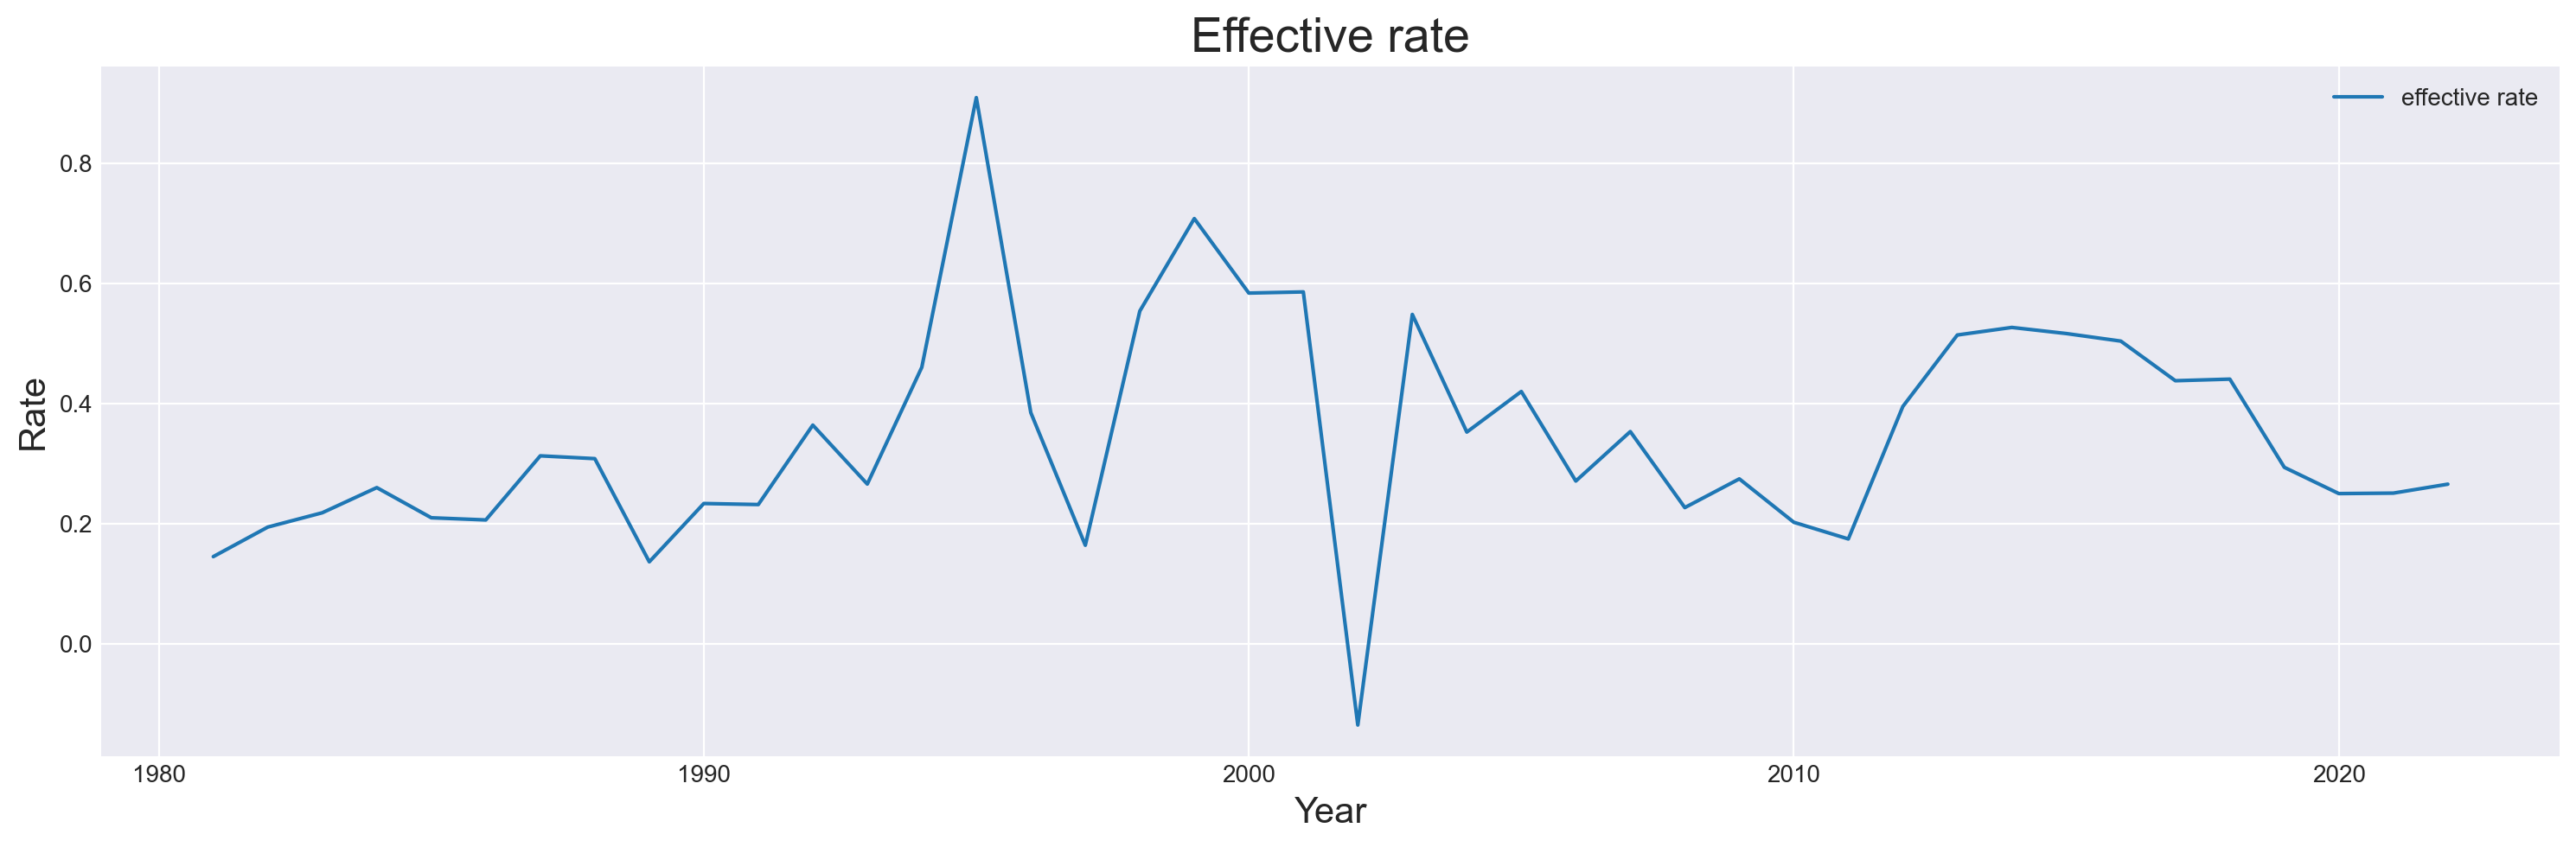

In [214]:
plt.plot(rates['Effective rate'],label = 'effective rate')
plt.title('Effective rate',size = 20)
plt.xlabel('Year',size = 15)
plt.ylabel('Rate',size = 15)
plt.legend()
plt.show()

In [215]:
effective_rates = list(rates['Effective rate'].values)

In [216]:
# using vasicek interest rate model to model evolution of effective rates
vasicek = vasicek_model(data = effective_rates,number_of_prediction_points = 7)

In [217]:
vasicek.mean_reversion

In [218]:
vasicek.volatility

In [219]:
# fitting model
vasicek.fit()

$$ E \left[ r_{t} \mid r_{0} \right]= r_{0}e^{-\kappa \left( t \right)}+ \theta \left( 1-e^{-\kappa \left( t \right) }\right) $$

In [220]:
# expectation
vasicek.expectation()

[0.31097624315982414,
 0.3323827058253736,
 0.3424981801564191,
 0.34727817685838286,
 0.34953693089433163,
 0.35060428932845333,
 0.35110866209713865]

In [221]:
expected_effective_rates = pd.DataFrame({'Rates':vasicek.expectation()},index = list(range(2023,2023 + len(vasicek.expectation()))))

In [222]:
expected_effective_rates

,Rates
2023,0.310976
2024,0.332383
2025,0.342498
2026,0.347278
2027,0.349537
2028,0.350604
2029,0.351109


In [223]:
# variance
vasicek.variance()

[0.009309333575358203,
 0.011388078881527227,
 0.011852256259310521,
 0.011955905627709026,
 0.011979050210111369,
 0.011984218323558228,
 0.011985372347257396]

In [224]:
# ols model results
vasicek.ols_model_results()

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     24.03
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.70e-05
Time:                        10:12:39   Log-Likelihood:                 13.424
No. Observations:                  41   AIC:                            -22.85
Df Residuals:                      39   BIC:                            -19.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2635      0.060      4.389      0.0

In [225]:
# defining pv total premium dataframe
pv_total_premium = Total_premium.join([expected_effective_rates])

In [226]:
#pv_total_premium.drop(['Ratio','Pure premium','Gross rate','Exposures','Exposures shift()'],axis = 'columns',inplace = True)

In [227]:
pv_total_premium

,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Total gross rates,Rates
2025,0.027236,22.381998,23.008669,2203399.0,2147596.0,4.941332e+07,0.342498
2026,0.029679,25.198394,25.969142,2260115.0,2203399.0,5.722038e+07,0.347278
2027,0.032270,28.370370,29.316421,2317627.0,2260115.0,6.625848e+07,0.349537
2028,0.035024,31.944537,33.103969,2375855.0,2317627.0,7.672265e+07,0.350604
2029,0.037958,35.973275,37.392608,2434788.0,2375855.0,8.883941e+07,0.351109


In [228]:
add_2024 = pd.DataFrame({'Total gross rates':np.nan,'Rates':expected_effective_rates.Rates[2024]},index = [2024])

In [229]:
pv_total_premium = pd.concat([add_2024,pv_total_premium])

In [230]:
pv_total_premium

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift()
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0


In [231]:
# since effective rates in the years before are the ones used in computation of present values
pv_total_premium['Rates shift()'] = pv_total_premium.Rates.shift()

In [232]:
pv_total_premium

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Rates shift()
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN,NaN
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0,0.332383
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0,0.342498
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0,0.347278
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0,0.349537
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0,0.350604


In [233]:
class Time_value():
    
    def future_value(amount : float,interest_rate : float, periods : float):

        return amount * ((1 + interest_rate) ** periods )
        
    def present_value(amount : float,interest_rate : float, periods : float):

        return amount * (1 / ((1 + interest_rate) ** periods))

$$amount * \frac{1}{(1 + interest \quad rate) ^ {periods}}$$ where periods is 1

In [234]:
# defining pv gross rate column
pv_total_premium['PV gross rates, year(-1)'] = pv_total_premium.apply(lambda col:Time_value.present_value(col['Total gross rates'],col['Rates shift()'],1),axis = 'columns')

In [235]:
pv_total_premium

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Rates shift(),"PV gross rates, year(-1)"
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0,0.332383,3.708644e+07
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0,0.342498,4.262232e+07
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0,0.347278,4.917951e+07
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0,0.349537,5.685110e+07
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0,0.350604,6.577753e+07


In [236]:
class Annuity:
    
    def __init__(self,interest_rate : float,number_of_terms : int,amount : float = 1):
        self.interest_rate = interest_rate
        self.number_of_terms = number_of_terms
        self.amount = amount
        
    def certain_present_value(self):
        
        return self.amount*((1-(1+self.interest_rate)**(-self.number_of_terms))/self.interest_rate)
        
    def certain_future_value(self):
        
        return self.amount*((((1+self.interest_rate)**self.number_of_terms)-1)/self.interest_rate)
        
    def due_present_value(self):
        
        return self.amount*((1-(1+self.interest_rate)**(-self.number_of_terms))/(self.interest_rate/(self.interest_rate + 1)))
        
    def due_future_value(self):
        
        return self.amount*((((1+self.interest_rate)**self.number_of_terms)-1)/(self.interest_rate/(self.interest_rate + 1)))

\begin{aligned} \text{PV}_{\text{Ordinary~Annuity}} = \text{C} \times \left [ \frac { 1 - (1 + i) ^ { -n }}{ i } \right ] \\ \end{aligned}  where C is 1

In [237]:
# defining pv annuity certain column
pv_total_premium['PV annuity certain(1), year(-1)'] = pv_total_premium.apply(lambda col:Annuity(interest_rate = col['Rates shift()']/12,number_of_terms = 12,amount = 1).certain_present_value(),axis = 'columns')

In [238]:
pv_total_premium

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Rates shift(),"PV gross rates, year(-1)","PV annuity certain(1), year(-1)"
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0,0.332383,3.708644e+07,10.092153
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0,0.342498,4.262232e+07,10.041226
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0,0.347278,4.917951e+07,10.017293
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0,0.349537,5.685110e+07,10.006013
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0,0.350604,6.577753e+07,10.000689


In [239]:
# defining tax dataframe
tax_df = pv_total_premium

In [240]:
tax_df

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Rates shift(),"PV gross rates, year(-1)","PV annuity certain(1), year(-1)"
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0,0.332383,3.708644e+07,10.092153
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0,0.342498,4.262232e+07,10.041226
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0,0.347278,4.917951e+07,10.017293
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0,0.349537,5.685110e+07,10.006013
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0,0.350604,6.577753e+07,10.000689


$$ T = PV_{T rates} / (N* PV_{annuity})$$

In [241]:
# defining tax column(1), calculating tax
tax_df['Tax, year(-1)'] = tax_df['PV gross rates, year(-1)'] / (tax_df['Exposures shift()'] * tax_df['PV annuity certain(1), year(-1)'])

In [242]:
tax_df

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Rates shift(),"PV gross rates, year(-1)","PV annuity certain(1), year(-1)","Tax, year(-1)"
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0,0.332383,3.708644e+07,10.092153,1.711113
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0,0.342498,4.262232e+07,10.041226,1.926447
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0,0.347278,4.917951e+07,10.017293,2.172217
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0,0.349537,5.685110e+07,10.006013,2.451513
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0,0.350604,6.577753e+07,10.000689,2.768393


In [243]:
# defining tax column(2), calculating tax
tax_df['Tax'] = tax_df['Tax, year(-1)'].shift(-1)

In [244]:
tax_df

,Total gross rates,Rates,Ratio,Pure premium,Gross rate,Exposures,Exposures shift(),Rates shift(),"PV gross rates, year(-1)","PV annuity certain(1), year(-1)","Tax, year(-1)",Tax
2024,NaN,0.332383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.711113
2025,4.941332e+07,0.342498,0.027236,22.381998,23.008669,2203399.0,2147596.0,0.332383,3.708644e+07,10.092153,1.711113,1.926447
2026,5.722038e+07,0.347278,0.029679,25.198394,25.969142,2260115.0,2203399.0,0.342498,4.262232e+07,10.041226,1.926447,2.172217
2027,6.625848e+07,0.349537,0.032270,28.370370,29.316421,2317627.0,2260115.0,0.347278,4.917951e+07,10.017293,2.172217,2.451513
2028,7.672265e+07,0.350604,0.035024,31.944537,33.103969,2375855.0,2317627.0,0.349537,5.685110e+07,10.006013,2.451513,2.768393
2029,8.883941e+07,0.351109,0.037958,35.973275,37.392608,2434788.0,2375855.0,0.350604,6.577753e+07,10.000689,2.768393,NaN


In [245]:
tax_df.to_csv('tax_df.csv')